In [ ]:
#Setup Code

data_dir = "../data"

import csv
import warnings
import pickle

from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice, chain, count, product
from contextlib import nullcontext
from concurrent.futures import ProcessPoolExecutor
from typing import Union

import torch
import torch.utils.data
import coba as cb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from parameterfree import COCOB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

try:
    torch.set_num_threads(3)
    torch.set_num_interop_threads(3)
except RuntimeError:
    pass

c0 = "#444"
c1 = "#0072B2"
c2 = "#E69F00"
c3 = "#009E73"
c4 = "#56B4E9"
c5 = "#D55E00"
c6 = "#F0E442"
c7 = "#CC79A7"
c8 = "#000000"
c9 = "#332288"

torch.set_default_device('cpu')
plt.rc('font', **{'size': 20})

def batched(iterable, n, *, strict=False):
    # batched('ABCDEFG', 2) → AB CD EF G
    if n < 1:
        raise ValueError('n must be at least one')
    iterator = iter(iterable)
    while batch := tuple(islice(iterator, n)):
        if strict and len(batch) != n:
            raise ValueError('batched(): incomplete batch')
        yield batch

def make_emotions_df():

    def add_day_columns(df, timestamp_col, participant_df):
        return add_rel_day(add_start_day(add_day(df, timestamp_col), participant_df))

    def add_day(df, timestamp_col):
        df = df.copy()
        df["Day"] = (df[timestamp_col]/(60*60*24)).apply(np.floor)
        return df

    def add_start_day(df, participant_df):
        participant_df = participant_df.copy()
        participant_df["StartDay"] = (participant_df["DataStartStampUtc"]/(60*60*24)).apply(np.floor)
        return pd.merge(df, participant_df[['ParticipantId',"StartDay"]])

    def add_rel_day(df):
        df = df.copy()
        df["RelDay"] = df["Day"]-df["StartDay"]
        return df

    def drop_all1_ends(df):
        last, last_gt_1, keep = df.copy(),df.copy(), df.copy()
        
        last_gt_1 = last_gt_1[last_gt_1["State Anxiety"]!= 1]
        last_gt_1 = last_gt_1.groupby("ParticipantId")["RelDay"].max().reset_index()
        last_gt_1 = last_gt_1.rename(columns={"RelDay":"Last Day > 1"})

        last = last.groupby("ParticipantId")["RelDay"].max().reset_index()
        last = last.rename(columns={"RelDay":"Last Day"})

        for pid in last["ParticipantId"]:
            
            last_day = last[last["ParticipantId"]==pid]["Last Day"].item()
            last_day_gt_1 = last_gt_1[last_gt_1["ParticipantId"]==pid]["Last Day > 1"].item()
            
            if last_day-last_day_gt_1 >= 3:
                is_not_pid = keep["ParticipantId"] != pid
                is_lt_day  = keep["RelDay"] <= last_day_gt_1
                keep = keep[is_not_pid | is_lt_day]

        return keep

    emotions_df = pd.read_csv(f'{data_dir}/Emotions.csv')
    participant_df = pd.read_csv(f'{data_dir}/Participants.csv')

    emotions_df = emotions_df[emotions_df["WatchDataQuality"] == "Good"]

    emotions_df["State Anxiety"] = pd.to_numeric(emotions_df["State Anxiety"], errors='coerce')
    emotions_df["ER Interest"] = pd.to_numeric(emotions_df["ER Interest"], errors='coerce')
    emotions_df["Phone ER Interest"] = pd.to_numeric(emotions_df["Phone ER Interest"], errors='coerce')
    emotions_df["Response Time (min)"] = (emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])/60
    emotions_df["Response Time (sec)"] = (emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])
    emotions_df["Response Time (log min)"] = np.log((1+ emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])/60)
    emotions_df["Response Time (log sec)"] = np.log((1+ emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"]))

    emotions_df["State Anxiety (z)"] = float('nan')
    emotions_df["ER Interest (z)"] = float('nan')

    for pid in set(emotions_df["ParticipantId"].tolist()):
        is_pid = emotions_df["ParticipantId"] == pid
        is_anx = emotions_df["State Anxiety"] > 1
        emotions_df.loc[is_pid,["ER Interest (z)"]] = StandardScaler().fit_transform(emotions_df.loc[is_pid,["ER Interest"]])
        emotions_df.loc[is_pid&is_anx,["State Anxiety (z)"]] = StandardScaler().fit_transform(emotions_df.loc[is_pid&is_anx,["State Anxiety"]])

    emotions_df = add_day_columns(emotions_df, "DeliveredTimestampUtc", participant_df)

    emotions_df = emotions_df[emotions_df["RelDay"] < 11]

    return drop_all1_ends(emotions_df)

emotions_df = make_emotions_df()

class TheoryGridCellSpatialRelationEncoder:
    #https://arxiv.org/pdf/2003.00824
    def __init__(self, coord_dim = 2, frequency_num = 16, max_radius = 10000,  min_radius = 1000, freq_init = "geometric"):
        """
        Args:
            coord_dim: the dimention of space, 2D, 3D, or other
            frequency_num: the number of different sinusoidal with different frequencies/wavelengths
            max_radius: the largest context radius this model can handle
        """

        self.frequency_num = frequency_num
        self.coord_dim = coord_dim 
        self.max_radius = max_radius
        self.min_radius = min_radius
        self.freq_init = freq_init

        # the frequency we use for each block, alpha in ICLR paper
        self.cal_freq_list()
        
        # freq_mat shape: (frequency_num, 1)
        freq_mat = np.expand_dims(self.freq_list, axis = 1)
        # self.freq_mat shape: (frequency_num, 6)
        self.freq_mat = np.repeat(freq_mat, 6, axis = 1)

        # there unit vectors which is 120 degree apart from each other
        self.unit_vec1 = np.asarray([1.0, 0.0])                        # 0
        self.unit_vec2 = np.asarray([-1.0/2.0, np.sqrt(3)/2.0])      # 120 degree
        self.unit_vec3 = np.asarray([-1.0/2.0, -np.sqrt(3)/2.0])     # 240 degree

        # compute the dimention of the encoded spatial relation embedding
        self.input_embed_dim = int(6 * self.frequency_num)
        
    def cal_freq_list(self):
        if self.freq_init == "random":
            self.freq_list = np.random.random(size=[self.frequency_num]) * self.max_radius
        elif self.freq_init == "geometric":
            log_timescale_increment = (np.log(float(self.max_radius) / float(self.min_radius)) /(self.frequency_num*1.0 - 1))
            timescales = self.min_radius * np.exp(np.arange(self.frequency_num).astype(float) * log_timescale_increment)
            self.freq_list = 1.0/timescales
        else:
            raise Exception()

    def make_input_embeds(self, coords):
        if type(coords) == np.ndarray:
            assert self.coord_dim == np.shape(coords)[2]
            coords = list(coords)
        elif type(coords) == list:
            coords = [[c] for c in coords]
            assert self.coord_dim == len(coords[0][0])
        else:
            raise Exception("Unknown coords data type for GridCellSpatialRelationEncoder")

        # (batch_size, num_context_pt, coord_dim)
        coords_mat = np.asarray(coords).astype(float)
        batch_size = coords_mat.shape[0]
        num_context_pt = coords_mat.shape[1]

        # compute the dot product between [deltaX, deltaY] and each unit_vec 
        # (batch_size, num_context_pt, 1)
        angle_mat1 = np.expand_dims(np.matmul(coords_mat, self.unit_vec1), axis = -1)
        # (batch_size, num_context_pt, 1)
        angle_mat2 = np.expand_dims(np.matmul(coords_mat, self.unit_vec2), axis = -1)
        # (batch_size, num_context_pt, 1)
        angle_mat3 = np.expand_dims(np.matmul(coords_mat, self.unit_vec3), axis = -1)

        # (batch_size, num_context_pt, 6)
        angle_mat = np.concatenate([angle_mat1, angle_mat1, angle_mat2, angle_mat2, angle_mat3, angle_mat3], axis = -1)
        # (batch_size, num_context_pt, 1, 6)
        angle_mat = np.expand_dims(angle_mat, axis = -2)
        # (batch_size, num_context_pt, frequency_num, 6)
        angle_mat = np.repeat(angle_mat, self.frequency_num, axis = -2)
        # (batch_size, num_context_pt, frequency_num, 6)
        angle_mat = angle_mat * self.freq_mat
        # (batch_size, num_context_pt, frequency_num*6)
        spr_embeds = np.reshape(angle_mat, (batch_size, num_context_pt, -1))

        # make sinuniod function
        # sin for 2i, cos for 2i+1
        # spr_embeds: (batch_size, num_context_pt, frequency_num*6=input_embed_dim)
        spr_embeds[:, :, 0::2] = np.sin(spr_embeds[:, :, 0::2])  # dim 2i
        spr_embeds[:, :, 1::2] = np.cos(spr_embeds[:, :, 1::2])  # dim 2i+1
        
        return spr_embeds.squeeze().tolist()

def is_gt(values,val):
    out = (values > val).astype(float)
    out[values.isna()] = float('nan')
    return out

def is_lt(values,val):
    out = (values < val).astype(float)
    out[values.isna()] = float('nan')
    return out

def scale(values):
    with warnings.catch_warnings():
        # If a column has all nan then a warning is thrown
        # We supress that warning because that can happen
        warnings.simplefilter("ignore")
        return StandardScaler().fit_transform(values).tolist()

def add1(X):
    for x,z in zip(X,np.isnan(X).all(axis=1).astype(int)):
        x.append(z)
    return X

def wins(file_path, timestamps, window_len):
    file = open(file_path) if Path(file_path).exists() else nullcontext()
    rows = islice(csv.reader(file),1,None) if Path(file_path).exists() else [] #type: ignore

    with file:
        for timestamp in timestamps:
            window = []
            for row in rows:
                if float(row[0]) < timestamp-window_len: continue
                if float(row[0]) >= timestamp: break
                data = map(float,row[1:])
                window.append(next(data) if len(row) == 2 else tuple(data))
            yield window

def dems(pid, timestamps):
    df = pd.read_csv(f'{data_dir}/Baseline.csv')
    i = df["pid"].tolist().index(pid)
    return df.to_numpy()[[i]*len(timestamps), 1:].tolist()

def cacher(sensor,pid,ts,maker,*args):
    filename = f"{sensor}_{int(sum(ts))}_{args}_{pid}.pkl"
    features = load_feats(filename)
    if features: return features
    features = maker(pid,ts,*args)
    save_feats(filename,features)
    return features

def hrs(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/HeartRate.csv", timestamps, secs):
        w = list(filter(None,w))
        if w: features.append([np.mean(w),np.std(w)])
        else: features.append([float('nan')]*2)
    assert len(set(map(len,features))) == 1, 'hrs'
    return scale(features)

def scs1(pid, timestamps, secs):
    features = []
    if features: return features

    for w in wins(f"{data_dir}/watch/{pid}/StepCount.csv", timestamps, secs):
        if len(w)>1: features.append([np.mean(np.diff(w)),np.std(np.diff(w))])
        else: features.append([float('nan')]*2)
    assert len(set(map(len,features))) == 1, 'scs1'

    return scale(features)

def scs2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/StepCount.csv", timestamps, secs):
        if len(w)>1: features.append([np.max(w)-np.min(w)])
        else: features.append([float('nan')])
    assert len(set(map(len,features))) == 1, 'scs2'
    return scale(features)

def lins1(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([*np.var(w,axis=0),*np.percentile([np.linalg.norm(w,axis=1)],q=[10,50,90])])
        else: features.append([float('nan')]*6)
    assert len(set(map(len,features))) == 1, 'lins1'
    return scale(features)

def lins2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([*np.var(w,axis=0),*np.percentile([np.linalg.norm(w,axis=1)],q=[10,50,90])])
        else: features.append([float('nan')]*6)
    assert len(set(map(len,features))) == 1, 'lins2'
    return scale(features)

def lins3(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([np.mean(np.linalg.norm(w,axis=1)), *np.std(w,axis=0)])
        else: features.append([float('nan')]*4)
    assert len(set(map(len,features))) == 1, 'lins3'
    return scale(features)

def lins4(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([np.mean(np.linalg.norm(w,axis=1)), *np.std(w,axis=0)])
        else: features.append([float('nan')]*4)
    assert len(set(map(len,features))) == 1, 'lins2'
    return scale(features)

def bats1(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Battery.csv", timestamps, secs):
        w = [float(w)/100 for w in w]
        if len(w)==1: features.append([0,float('nan'),float('nan')])
        elif len(w)>1: features.append([np.max(w)-np.min(w),np.mean(np.diff(w)),np.std(np.diff(w))])
        else: features.append([float('nan')]*3)
        assert len(set(map(len,features))) == 1, 'bats1'
    return features

def bats2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Battery.csv", timestamps, secs):
        w = [float(w)/100 for w in w]
        if w: features.append([np.mean(w),np.max(w)-np.min(w)])
        else: features.append([float('nan')]*2)
        assert len(set(map(len,features))) == 1, 'bats2'
    return features

def peds1(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Pedometer.csv", timestamps, secs):
        if len(w)==1: features.append([float('nan'),0,float('nan')])
        elif len(w)>1: features.append([np.mean(np.diff(w)),np.max(w)-np.min(w),np.std(np.diff(w))])
        else: features.append([float('nan')]*3)
        assert len(set(map(len,features))) == 1, 'peds1'
    return scale(features)

def peds2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Pedometer.csv", timestamps, secs):
        if len(w)>1: features.append([np.max(w)-np.min(w)])
        else: features.append([float('nan')])
        assert len(set(map(len,features))) == 1, 'peds2'
    return scale(features)

def locs1(pid, timestamps, secs, freq, lmin, lmax):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Location.csv", timestamps, secs):
        if w: features.append([*np.mean(w,axis=0)[1:]])
        else: features.append([float('nan')]*2)
    out = TheoryGridCellSpatialRelationEncoder(frequency_num=freq,min_radius=lmin,max_radius=lmax,freq_init='geometric').make_input_embeds(features)
    return [out] if len(timestamps) == 1 else out

def locs2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Location.csv", timestamps, secs):
        if w: features.append([*np.mean(w,axis=0)[1:]])
        else: features.append([float('nan')]*2)
    return features

def tims(timestamps,tzs):
    hour, day = 60*60, 60*60*24
    for timestamp,tz in zip(timestamps,tzs):
        if np.isnan(timestamp): 
            yield [float('nan')]*3
        else:
            if   tz == "-04:00": timestamp -= 4*hour
            elif tz == "-05:00": timestamp -= 5*hour
            time_of_day = (timestamp/day) % 1
            day_of_week = (int(timestamp/day)+4) % 7
            is_weekend = day_of_week in [0,6]
            is_weekday = day_of_week in [1,2,3,4,5]
            yield [time_of_day,int(is_weekend),int(is_weekday)]

def save_feats(filename,feats):
    if not Path(f"{data_dir}/feats/{filename}").exists():
        with open(f"{data_dir}/feats/{filename}", "wb") as f: # Use "wb" for binary write mode
            pickle.dump(feats, f)

def load_feats(filename):
    if not Path(f"{data_dir}/feats/{filename}").exists():
        return None
    else:
        try:
            with open(f"{data_dir}/feats/{filename}", "rb") as f: # Use "wb" for binary write mode
                return pickle.load(f)
        except:
            Path(f"{data_dir}/feats/{filename}").unlink()
            return None

def make_xyg2(work_item):
    (pid,ts,tz,ys,args,secs) = work_item

    fs = []

    if secs == None:
        if args[1]: fs.append(list(cacher("hrs"  ,pid,ts,hrs  ,args[1])))
        if args[2]: fs.append(list(cacher("scs2" ,pid,ts,scs2 ,args[2])))
        if args[3]: fs.append(list(cacher("lins3",pid,ts,lins3,args[3])))
        if args[4]: fs.append(list(cacher("lins4",pid,ts,lins4,args[4])))
        if args[5]: fs.append(list(cacher("bats2",pid,ts,bats2,args[5])))
        if args[6]: fs.append(list(cacher("peds2",pid,ts,peds2,args[6])))
        if args[7]: fs.append(list(cacher("locs1",pid,ts,locs1,*args[7])))

        if args[9]:
            for f in fs: add1(f)

        if args[0]: fs.append(list(tims(ts,tz)))
        if args[8]: fs.append(list(dems(pid,ts)))

        _xs = [list(chain.from_iterable(feats)) for feats in zip(*fs)]
        _ys = list(ys)
        _gs = [pid]*len(ys)
    
    else:
        _xs,_ys,_gs = [],[],[]
        for sec in (secs or []):
            nts = [t+sec for t in ts]
            nxs,nys,ngs = make_xyg2((pid,nts,tz,ys,args,None))
            _xs += nxs
            _ys += nys
            _gs += ngs

    return _xs,_ys,_gs

can_predict = emotions_df.copy().sort_values(["ParticipantId","DeliveredTimestampUtc"])

def work_items(tims:bool,hrs:int,scs:int,lins1:int,lins2:int,bats:int,peds:int,locs1,dems:bool,add1:bool,event:str,secs=[0]):

    df = can_predict[~can_predict["SubmissionTimestampUtc"].isna()]

    if not isinstance(secs,(list,tuple)): secs = [secs]

    for pid in sorted(df["ParticipantId"].drop_duplicates().tolist()):
        ptc  = df[df.ParticipantId == pid]
        tss  = ptc["SubmissionTimestampUtc" if event == "sub" else "DeliveredTimestampUtc"].tolist() 
        tzs  = ptc["LocalTimeZone"].tolist()

        y0s = torch.tensor(is_gt(ptc["ER Interest (z)"],0).tolist())
        y1s = torch.tensor(is_lt(ptc['Response Time (min)'],10).tolist())
        y2s = torch.tensor(is_gt(ptc["State Anxiety (z)"],0).tolist())
        y3s = torch.tensor(is_gt(ptc["State Anxiety"], 1).tolist())
        y4s = torch.tensor(ptc["Response Time (log sec)"].tolist())
        y5s = torch.tensor(ptc["ER Interest (z)"].tolist())
        y6s = torch.tensor(ptc["State Anxiety (z)"].tolist())

        ys = torch.hstack((
            y0s.unsqueeze(1),
            y1s.unsqueeze(1),
            y2s.unsqueeze(1),
            y3s.unsqueeze(1),
            y4s.unsqueeze(1),
            y5s.unsqueeze(1),
            y6s.unsqueeze(1)
        )).tolist()

        args = [tims,hrs,scs,lins1,lins2,bats,peds,locs1,dems,add1]

        yield pid,tss,tzs,ys,args,secs

#with ProcessPoolExecutor(max_workers=20) as executor:
X,Y,G = zip(*map(make_xyg2, work_items(True,0,0,300,0,300,300,[300,2,1,2],False,True,"del")))

Y = torch.tensor(list(chain.from_iterable(Y))).float()
G = torch.tensor(list(chain.from_iterable(G))).int()
G = G[~torch.isnan(Y[:,[0,1]]).any(dim=1)]

testable_G = cb.CobaRandom(1).shuffle([k for k,n in Counter(G.tolist()).items() if n >= 30])

In [277]:
send, nosend = (1,0), (0,1)

class TL:
    def __init__(self, network: torch.nn.Module):
        self._network = network
        self._opt = COCOB(network.parameters())
        self._loss = torch.nn.BCEWithLogitsLoss()
        self._sig = torch.nn.Sigmoid()
        self.params = network.params

    def __deepcopy__(self,memo):
        return TL(self._network)

    def predict(self, features):
        with torch.no_grad():
            return self._sig(self._network(torch.tensor(features))).item()

    def learn(self, features, value, prob):
        self._opt.zero_grad()
        ((1/prob)*self._loss(self._network(torch.tensor(features)),torch.tensor([value]))).backward()
        self._opt.step()

class VWR:
    def __init__(self, args):
        self._args = args
        self.params = {'vwr_args':args}
        self.vw = cb.VowpalMediator()
        self.is_logistic = "logistic" in args
    def predict(self, features):
        if not self.vw.is_initialized: self.vw.init_learner(self._args, 1)
        return self.vw.predict(self.vw.make_example({"x":features})) #type: ignore
    def learn(self, features, value, prob):
        if not self.vw.is_initialized: self.vw.init_learner(self._args, 1)
        if self.is_logistic:
            assert value in [0,1]
            value = -1 if value == 0 else 1
        self.vw.learn(self.vw.make_example({"x":features}, f"{value} {1/prob}")) #type: ignore

class VWL:
    def __init__(self, args):
        self._args = args
        self.params = {'vwl_args':args}
        self.vw = cb.VowpalMediator()
        assert "logistic" in args
    def predict(self, features):
        if not self.vw.is_initialized: self.vw.init_learner(self._args, 1)
        return 1/(1+np.exp(-self.vw.predict(self.vw.make_example({"x":features})))) #type: ignore
    def learn(self, features, value, prob):
        if not self.vw.is_initialized: self.vw.init_learner(self._args, 1)
        assert value in [0,1]
        value = -1 if value == 0 else 1
        self.vw.learn(self.vw.make_example({"x":features}, f"{value} {1/prob}")) #type: ignore

class SquareCB:
    def __init__(self, vwr: Union[VWR,VWL], gamma, gamma_update):
        self.rng = cb.CobaRandom()
        self.vwr = vwr
        self.t = 0
        self.gamma = gamma
        self.gamma_update = gamma_update
        self.params = {**vwr.params,"gamma":gamma,"gamma_up":gamma_update.__name__}

    def predict(self, context, actions):
        gamma = self.gamma + self.gamma_update(self.t)
        p1 = self.vwr.predict(context)
        p0 = 1-p1

        minp = 1/(2+gamma*(abs(p1-p0)))

        if (self.rng.random() < minp):
            return (actions[0] if p1 <= p0 else actions[1]),minp
        else:
            return (actions[0] if p1 >= p0 else actions[1]),1-minp

    def learn(self, context, action, reward, probability):
        if action == (1,0):
            self.t+=1
            assert reward in [0,1]
            self.vwr.learn(context,reward,probability)

class GraphSquareCB:
    """An implementation of equation 7 and algorithm 1 in https://openreview.net/forum?id=l6pYRbuHpO"""

    def __init__(self, vw: Union[VWL,TL], gamma:float, power_t:float=.5, scale_t:float=1, sendr:float=1, mu:float=4, seed:int=1):
        self.vw = vw
        self.rng = cb.CobaRandom(seed)
        self.t = 0
        self.gamma = gamma
        self.power_t=power_t
        self.scale_t=scale_t
        self.sendr = sendr
        self.mu = mu
        self.params = {**vw.params, 'gamma': gamma, 'power_t':power_t, 'scale_t':scale_t, 'sendr':sendr, 'mu': mu, 'seed':seed}

    def predict(self,context,actions):
        gamma = self.gamma + self.scale_t*self.t**self.power_t

        f1 = self.vw.predict(context)
        f2 = 1-f1

        f1 *= self.sendr

        #Invert the values so our equations exactly match eq(7)
        #in the original paper. This reduces the chance for bugs.
        f1 = -f1
        f2 = -f2

        p1 = 1 if f1 <= f2 else 1/(self.mu+gamma*(f1-f2))
        p2 = 1-p1

        if self.rng.random() <= p1:
            return send,p1
        else:
            return nosend,p2

    def learn(self,context,action,reward,p):
        if action == (1,0):
            self.t+=1
            self.vw.learn(context,reward,p)

class MethodR:
    required_pretrain = []
    
    def warming(self):
        self.state = 'warming'
    
    def testing(self):
        self.state = 'testing'

    def __init__(self):
        self._cb_learner = cb.SafeLearner(cb.RandomLearner())

    def set_s(self,s):
        self._cb_learner.learner._rng = cb.CobaRandom(self._cb_learner.learner._rng.seed+s)

    def set_t(self,t):
        pass

    def predict(self,x0,x1,x2):
        return self._cb_learner.predict(x2, [send, nosend])

    def learn(self,x0,x1,x2,y0,y1,y2,a,p,**kwargs):
        pass

class MethodF:
    required_pretrain = []

    def warming(self):
        self.state = 'warming'
    
    def testing(self):
        self.state = 'testing'

    def __init__(self, pmf):
        self._cb_learner = cb.SafeLearner(cb.FixedLearner(pmf))
        self.params = {"pmf": pmf}

    def set_s(self,s):
        self._cb_learner.learner._pred._pmfrng = cb.CobaRandom(self._cb_learner.learner._pred._pmfrng.seed+s)

    def set_t(self,t):
        pass

    def predict(self,x0,x1,x2):
        return self._cb_learner.predict(x0, [send, nosend])

    def learn(self,x0,x1,x2,y0,y1,y2,a,p,**kwargs):
        pass

class Method0:
    required_pretrain = [2]

    def warming(self):
        self.state = 'warming'
    
    def testing(self):
        self.state = 'testing'

    def __init__(self, cb_learner):
        from copy import deepcopy
        self._cb_learner = deepcopy(cb.SafeLearner(cb_learner))
        self.params = {"method":0, **cb_learner.params}

    def set_s(self,s):
        try:
            self._cb_learner.rng = cb.Random(s) #type: ignore
        except:
            pass

    def set_t(self,t):
        try:
            self._cb_learner.t = t #type: ignore
        except:
            pass

    def predict(self,x0,x1,x2):
        return self._cb_learner.predict(x2, [send, nosend])

    def learn(self,x0,x1,x2,y0,y1,y2,a,p,**kwargs):
        r = y2 if a==send else .5
        self._cb_learner.learn(x2,a,r,p,**kwargs)

class Method1:
    """
    train a cb learner for y0 and y1 then pick send if they both choose send
    """
    required_pretrain = [0,1]

    def warming(self):
        self.state = 'warming'
    
    def testing(self):
        self.state = 'testing'

    def __init__(self, cb_learner):
        from copy import deepcopy
        self._cb_learner0 = deepcopy(cb.SafeLearner(cb_learner))
        self._cb_learner1 = deepcopy(cb.SafeLearner(cb_learner))
        self.params = {"method":1, **cb_learner.params}

    def set_s(self,s):
        try:
            self._cb_learner0.rng = cb.Random(s+0) #type: ignore
            self._cb_learner0.rng = cb.Random(s+1) #type: ignore
        except:
            pass

    def set_t(self,t):
        try:
            self._cb_learner0.t = t #type: ignore
            self._cb_learner1.t = t #type: ignore
        except:
            pass

    def predict(self,x0,x1,x2):
        a0,p0,o0 = self._cb_learner0.predict(x0, [send, nosend])
        a1,p1,o1 = self._cb_learner1.predict(x1, [send, nosend])
        p0send = p0 if a0 == send else 1-p0
        p1send = p1 if a1 == send else 1-p1
        a = send if a0==send and a1==send else nosend
        p = p0send*p1send if a == send else 1-p0send*p1send
        return a,p,{"o0":o0,"o1":o1}

    def learn(self,x0,x1,x2,y0,y1,y2,a,p,**kwargs):
        r0 = y0 if a==send else .5
        r1 = y1 if a==send else .5
        if not np.isnan(r0): self._cb_learner0.learn(x0,a,r0,p,**kwargs.get("o0",{}))
        self._cb_learner1.learn(x1,a,r1,p,**kwargs.get("o1",{}))

class Method2:
    """
    train a regression learner for y0 and y1 and then pass these in as features to cb_learner
    """

    def warming(self):
        self.state = 'warming'

    def testing(self):
        self.state = 'testing'

    required_pretrain = [0,1,2]
    def __init__(self, reg_learner: Union[VWR,VWL], cb_learner, sendonly:bool=False, testp:bool=False):
        from copy import deepcopy
        self._reg_learner0 = deepcopy(reg_learner)
        self._reg_learner1 = deepcopy(reg_learner)
        self._cb_learner   = deepcopy(cb.SafeLearner(cb_learner))
        self.sendonly = sendonly
        self.testp = testp
        self.params = {"method":2, **cb_learner.params, **reg_learner.params, 'sendonly': sendonly, 'testp': testp}

    def set_s(self,s):
        try:
            self._cb_learner.rng = cb.Random(s+0) #type: ignore
        except:
            pass

    def set_t(self,t):
        try:
            self._cb_learner.t = t #type: ignore
        except:
            pass

    def make_feats(self,x0,x1,x2):
        p0 = self._reg_learner0.predict(x0)
        p1 = self._reg_learner1.predict(x1)
        return [*x2,p0,p1,p0*p1]

    def predict(self,x0,x1,x2):
        a,p,o = self._cb_learner.predict(self.make_feats(x0,x1,x2), [send, nosend])

        if self.sendonly:
            return send, (p if a == send else 1-p), o
        else:
            return a,p,o

    def learn(self,x0,x1,x2,y0,y1,y2,a,p,**kwargs):
        p = p if self.state == "warming" else p if self.testp else 1
        r = y2 if a==send else .5
        self._cb_learner.learn(self.make_feats(x0,x1,x2),a,r,p,**kwargs)
        if not np.isnan(y0): self._reg_learner0.learn(x0,y0,p)
        self._reg_learner1.learn(x1,y1,p)

class Method3:
    required_pretrain = [0,1]

    def warming(self):
        self.state = 'warming'
        try:
            self._reg_learner0.warming()
            self._reg_learner1.warming()
        except:
            pass
    
    def testing(self):
        self.state = 'testing'
        try:
            self._reg_learner0.testing()
            self._reg_learner1.testing()
        except:
            pass

    def __init__(self, reg_learner: Union[VWL,TL], gamma:float, power_t:float=.5, scale_t:float=1, sendr:float=1, mu:float=4, sendonly:bool=False, posonly:bool=False, testp:bool=False, seed=1):
        from copy import deepcopy
        self._reg_learner0 = deepcopy(reg_learner)
        self._reg_learner1 = deepcopy(reg_learner)
        self.t = 0
        self.gamma = gamma
        self.power_t=power_t
        self.scale_t=scale_t
        self.sendr = sendr
        self.mu = mu
        self.sendonly = sendonly
        self.posonly = posonly
        self.testp = testp
        self.rng = cb.CobaRandom(seed)
        self.params = {"method":3, **reg_learner.params, 'gamma': gamma, 'power_t':power_t, 'scale_t':scale_t, 'sendr':sendr, 'mu': mu, 'seed':seed}

    def set_s(self,s):
        self.rng = cb.CobaRandom(self.rng.seed+s+1)

    def set_t(self,t):
        self.t = t

    def predict(self,x0,x1,x2):
        gamma = self.gamma + self.scale_t*self.t**self.power_t

        p0 = self._reg_learner0.predict(x0) # P(interested | x0)
        p1 = self._reg_learner1.predict(x1) # P(responsive | x1)

        f1 = p0*p1 # P( interested and  responsive | x0, x1) = P(is_interested | x0) * P(is_responsive | x1)
        f2 = 1-f1  # P(!interested  or !responsive | x0, x1) = 1 - P(interested and responsive | x0, x1)

        f1 *= self.sendr

        #Invert the values so our equations exactly match eq(7)
        #in the original paper. This reduces the chance for bugs.
        f1 = -f1
        f2 = -f2

        p1 = 1 if f1 <= f2 else 1/(self.mu+gamma*(f1-f2))
        p2 = 1-p1

        if self.sendonly:
            return send,p1,{}
        elif self.rng.random() <= p1:
            return send,p1,{}
        else:
            return nosend,p2,{}

    def learn(self,x0,x1,x2,y0,y1,y2,a,p):
        p = p if self.state == "warming" else p if self.testp else 1
        if a == send:
            self.t+=1
            if y2==1 or not self.posonly:
                if not np.isnan(y0) and (y0==1 or not self.posonly or self.state=="warming"): self._reg_learner0.learn(x0,y0,p)
                if not np.isnan(y1) and (y1==1 or not self.posonly or self.state=="warming"): self._reg_learner1.learn(x1,y1,p)

class Method4:
    required_pretrain = [2]

    def warming(self):
        self.state = 'warming'
    
    def testing(self):
        self.state = 'testing'

    def __init__(self, reg_learner: Union[VWR,VWL], gamma, gamma_update,  seed=1):
        from copy import deepcopy
        self._reg_learner0 = deepcopy(reg_learner)
        self._reg_learner1 = deepcopy(reg_learner)
        self.t = 0
        self.gamma = gamma
        self.gamma_update = gamma_update
        self.rng = cb.CobaRandom(seed)
        self.params = {"method":4, **reg_learner.params, "gamma": gamma, "gamma_up":gamma_update.__name__, 'seed':seed}

    def set_s(self,s):
        self.rng = cb.CobaRandom(self.rng.seed+s+1)

    def set_t(self,t):
        self.t = t

    def predict(self,x0,x1,x2):
        gamma = self.gamma + self.gamma_update(self.t)

        f1 = self._reg_learner0.predict(x2)
        f2 = self._reg_learner1.predict(x2)

        #Invert the values so our equations exactly match eq(7)
        #in the original paper. This reduces the chance for bugs.
        f1 = -f1
        f2 = -f2

        p1 = 1 if f1 <= f2 else 1/(4+gamma*(f1-f2))
        p2 = 1-p1

        if self.rng.random() <= p1:
            return send,p1,{}
        else:
            return nosend,p2,{}

    def learn(self,x0,x1,x2,y0,y1,y2,a,p):
        if a == send:
            self.t+=1
            self._reg_learner0.learn(x2,y2,p)
            self._reg_learner1.learn(x2,1-y2,p)


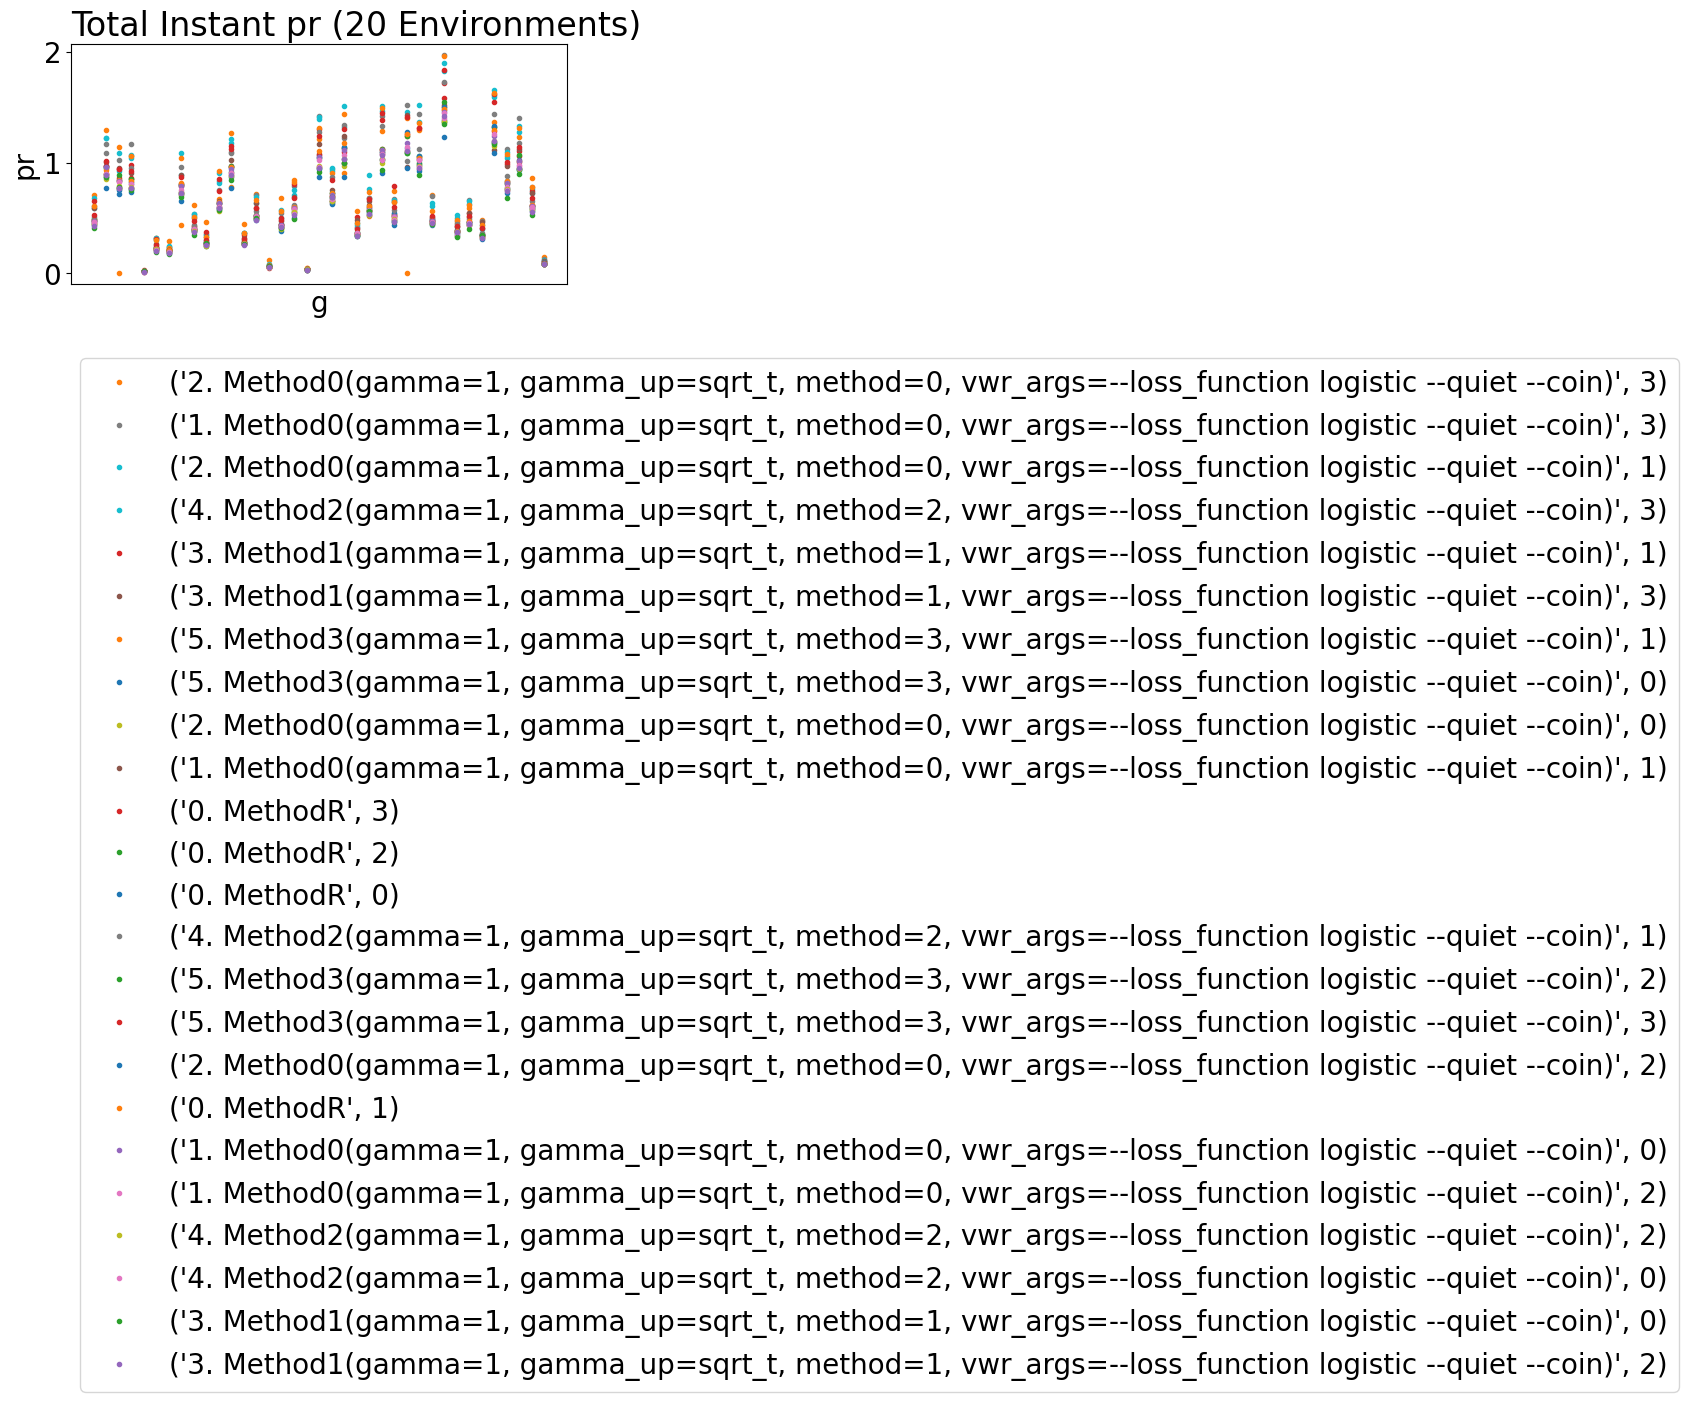

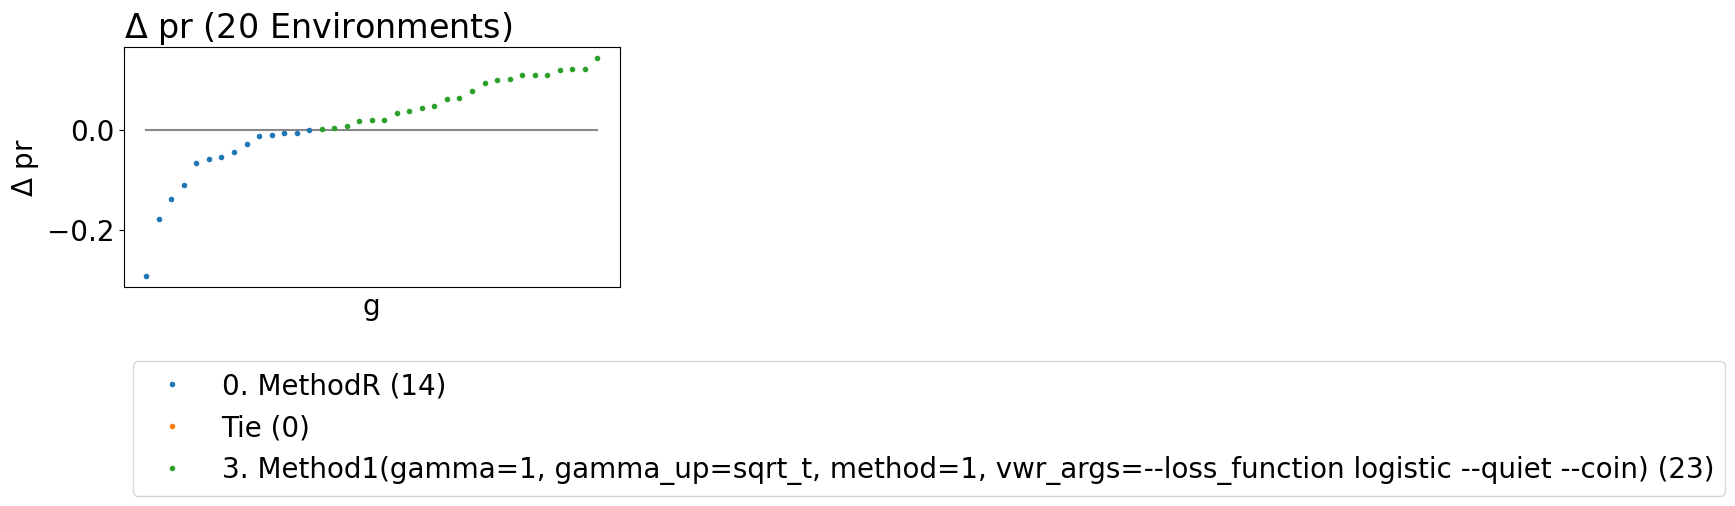

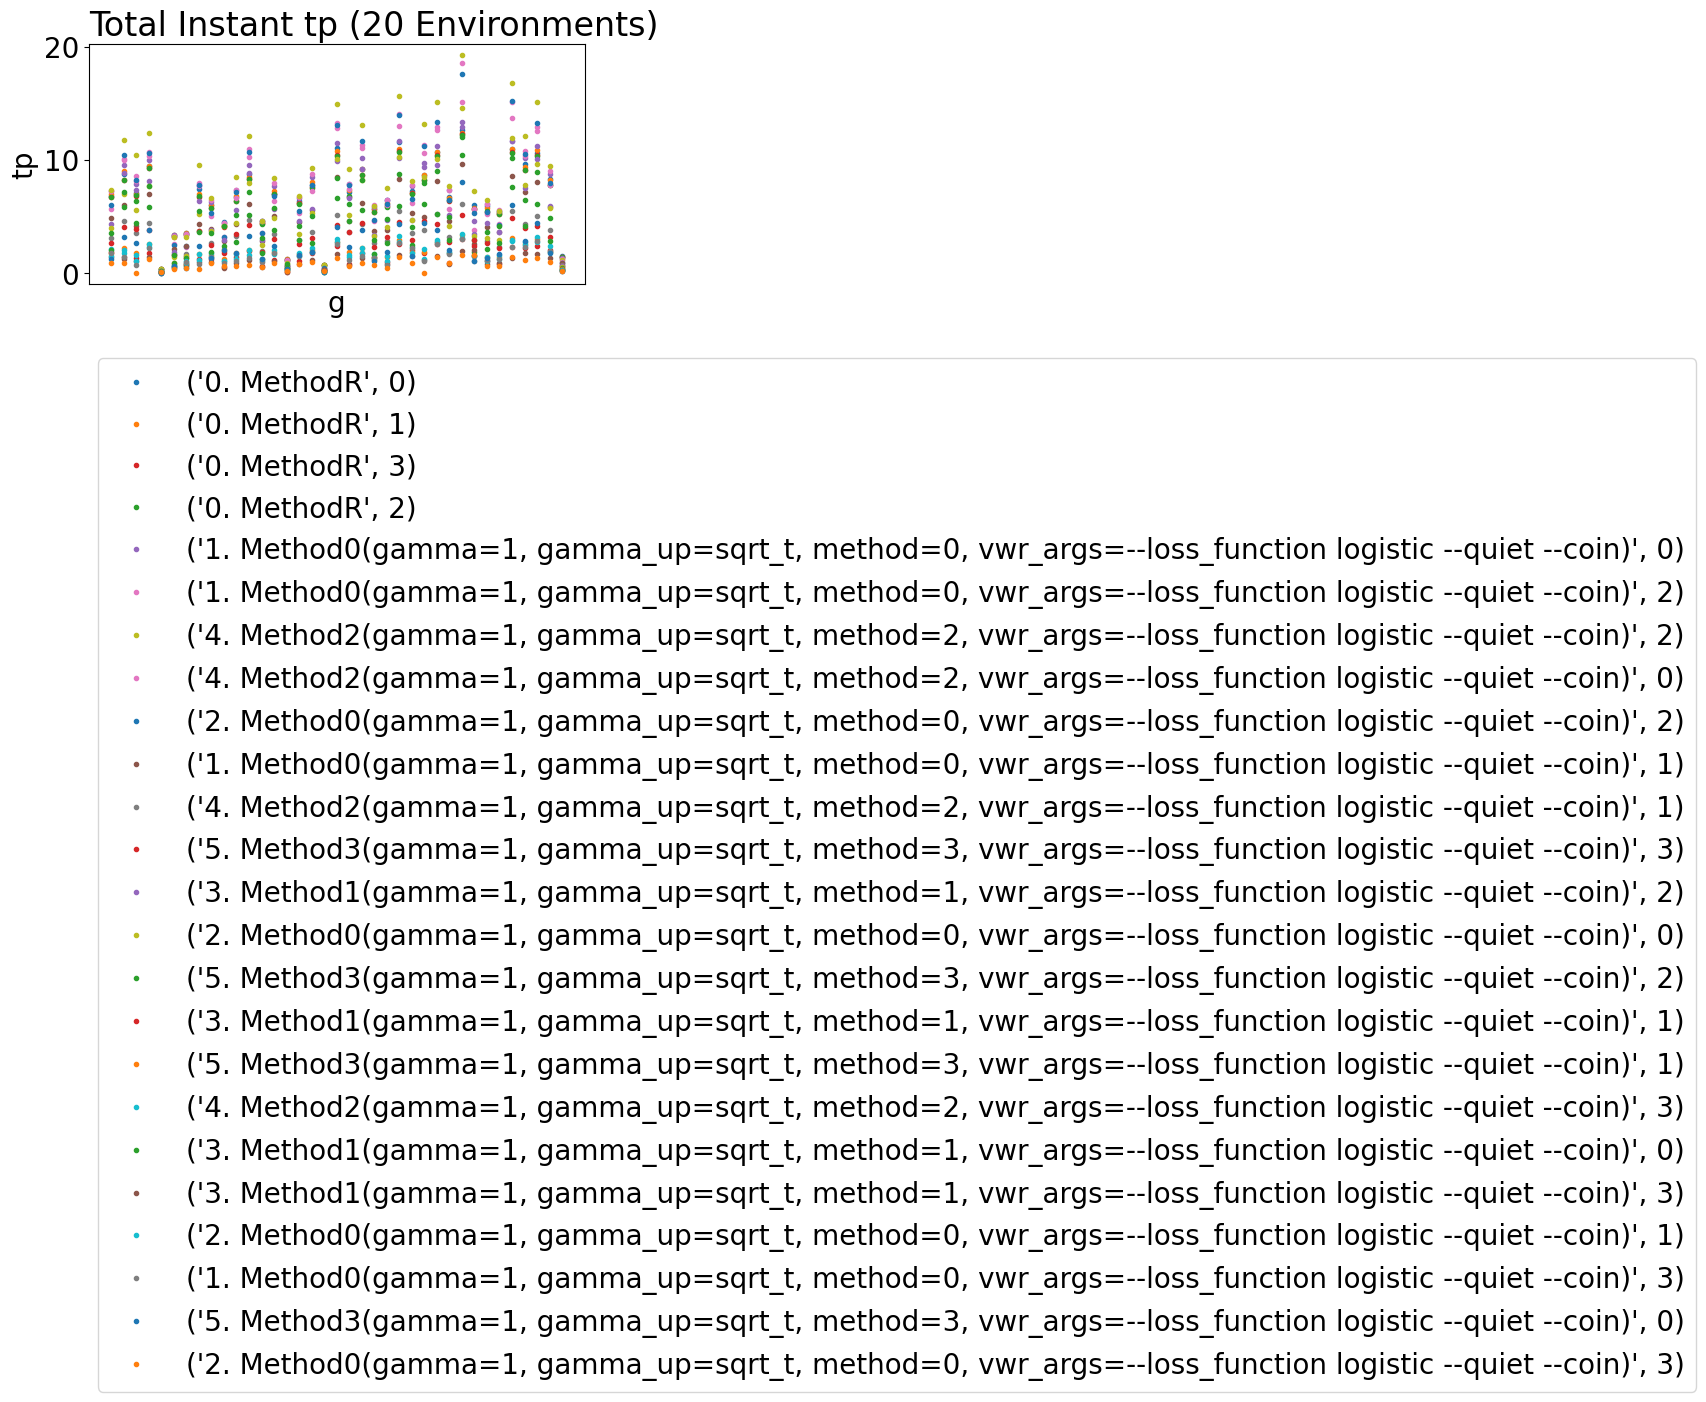

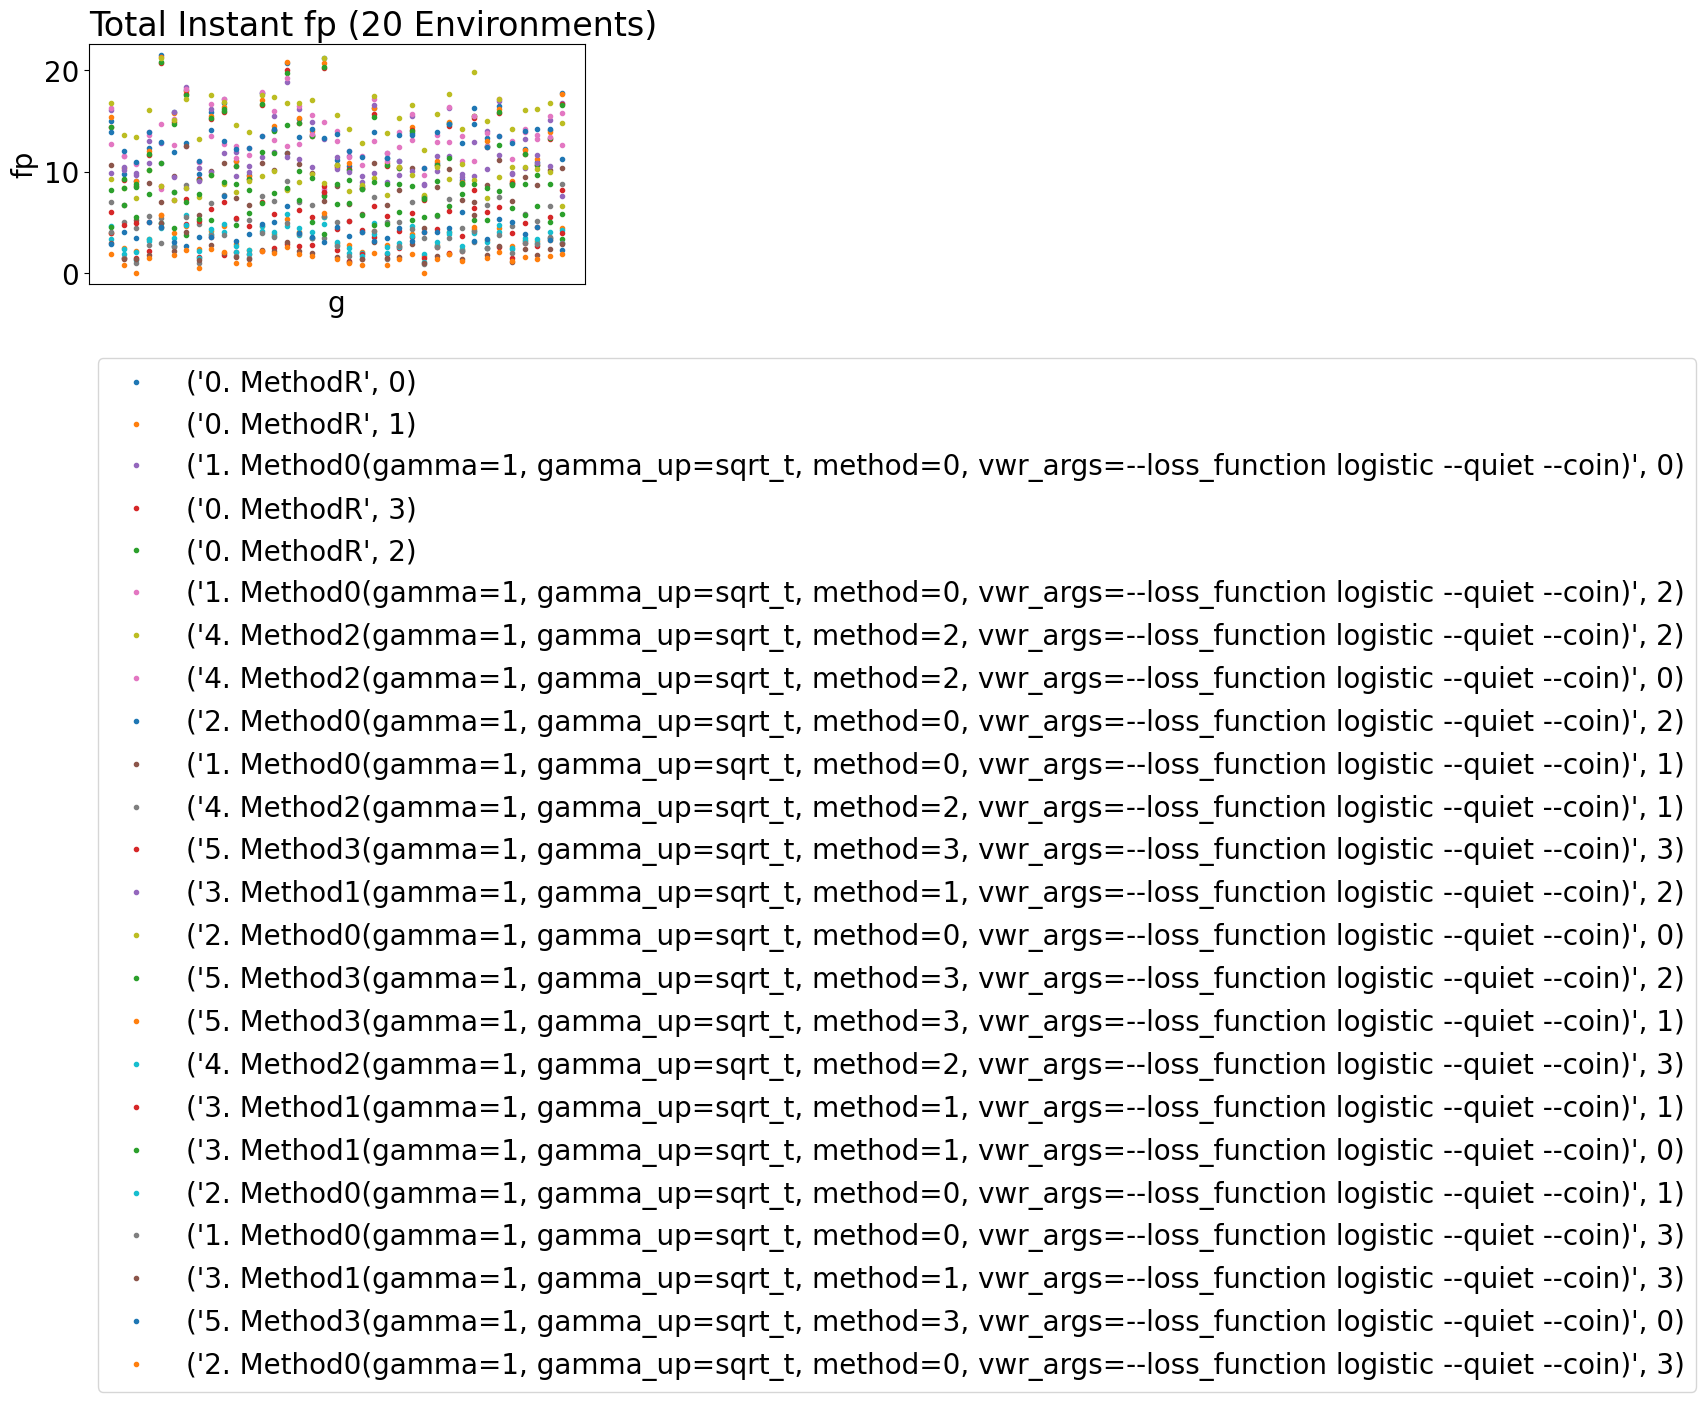

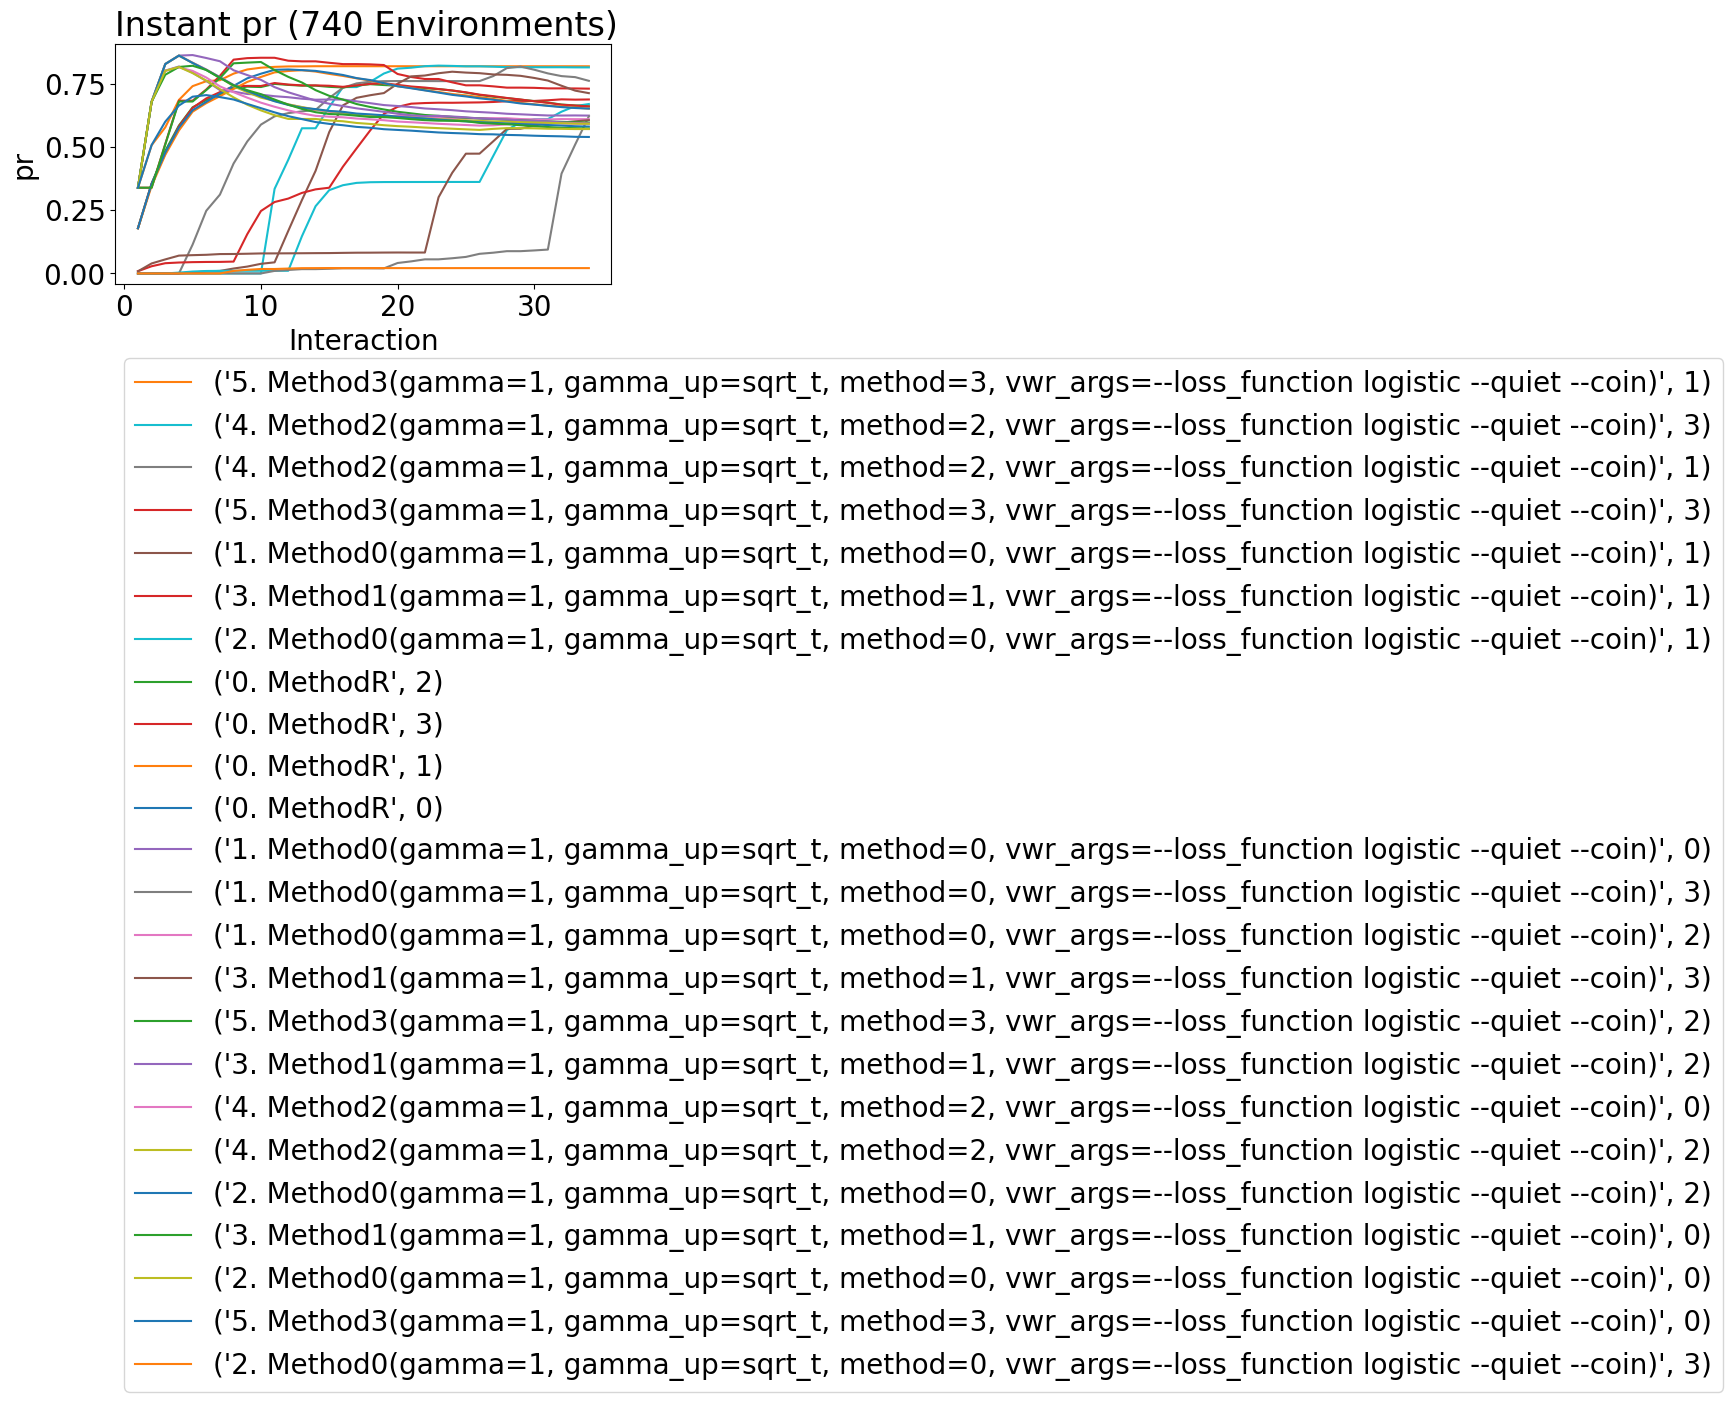

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            scores = []
            for j in range(30):

                rng = cb.CobaRandom(seed=j+env.params['rng'])
                rng_indexes = rng.shuffle(range(len(X0)))

                X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                lrn_ = deepcopy(lrn)

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,1)

                lrn_.set_s(env.params['rng']+j)
                lrn_.set_t(0)

                tp,fp,tn,fn = 0,0,0,0

                mems = []
                bits = []

                scores.append([])
                for i in range(min([len(Y0),45])):

                    a,p,y = None,None,None

                    with torch.no_grad():
                        x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                        x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                        x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                        y     = y2
                        a,p,o = lrn_.predict(x0,x1,x2)
                        bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                        mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                    if self.learn : bits.append(bit)
                    if self.replay: mems.append((mem,self.pers_mem_rpt))

                    if self.replay and len(mems) >= self.pers_mem_cnt:
                        rng.shuffle(mems, inplace=True)
                        for j in reversed(range(self.pers_mem_rcl)):
                            if j >= len(mems): continue
                            mem,n = mems[j]
                            bits.append(mem)
                            if n == 1: mems.pop(j)
                            else: mems[j] = [mem,n-1]

                    if self.learn and len(bits) >= self.pers_lrn_cnt:
                        for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                            lrn_.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                        del bits[:self.pers_lrn_cnt]

                    tp += int(a==send and y==1)
                    fp += int(a==send and y==0)
                    fn += int(a!=send and y==1)
                    tn += int(a!=send and y==0)

                    r = y if a==send else .5
                    c = y if a==send else 1-y

                    tpr = tp/((tp+fn) or 1)
                    fpr = fp/((tn+fp) or 1)

                    scores[-1].append({
                        'reward':r,
                        'correct':c,
                        'f1':2*tp/((2*tp+fp+tn) or 1),
                        'tp': tp,
                        'fp': fp,
                        'tn': tn,
                        'fn': fn,
                        'pr':tp/(fp or 1), #positive likelihood ratio
                        'plr':tpr/(fpr or 1), #positive likelihood ratio
                        'acc':(tp+tn)/(tp+fp+fn+tn),
                        'fpr':fp/((tn+fp) or 1),
                        'tpr':tp/((tp+fn) or 1), #sensitivity, recall
                        'tnr':tn/((tn+fp) or 1), #specificity
                        'ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                        'ppn':tn/((tn+fn) or 1), #negative precision, negative predictive value
                        'bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2
                    })

            for s in zip(*scores):
                yield {k:mean([s_[k] for s_ in s if k in s_]) for k in set().union(*s)}

        yield from get_scores(env)

def sqrt_t(t):
    return .25*t**(1/2)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

envs = [ MyEnvironment(a0,a1,a2,[g],rng) for g in testable_G for rng in range(20) ]
lrns = [
    MethodR(),
    Method0(SquareCB(VWR("--loss_function logistic --quiet --coin"), 1, sqrt_t)),
    Method0(GraphSquareCB(VWR("--loss_function logistic --quiet --coin"), 1, sqrt_t)),
    Method1(SquareCB(VWR("--loss_function logistic --quiet --coin"), 1, sqrt_t)),
    Method2(VWL("--loss_function logistic --quiet --coin"),GraphSquareCB(VWR("--loss_function logistic --quiet --coin"), 1, sqrt_t)),
    Method3(VWL("--loss_function logistic --quiet --coin"), 1, sqrt_t)
]

vals = [
    # ssl (v=2) + basis
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 0, 1, 0, 0, 0, []),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 0, 3, 2, 2, 2, []),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 3, 2, 2, 2, []),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 0, 1, 2, 2, 2, []),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 2, 2, 2, []),
]

#res = cb.Experiment(envs,lrns,vals).run('../logs/4/test.log.gz',processes=32,quiet=True) #type: ignore
res.plot_learners(x='g',y="pr",l=['full_name','evaluator_id'],span=1,xticks=False)
res.plot_contrast(0,3,l='learner_id',x='g',y='pr',span=1,xticks=False)
res.plot_learners(x='g',y="tp",l=['full_name','evaluator_id'],span=1,xticks=False)
res.plot_learners(x='g',y="fp",l=['full_name','evaluator_id'],span=1,xticks=False)
res.plot_learners(y="pr",l=['full_name','evaluator_id'],span=1)

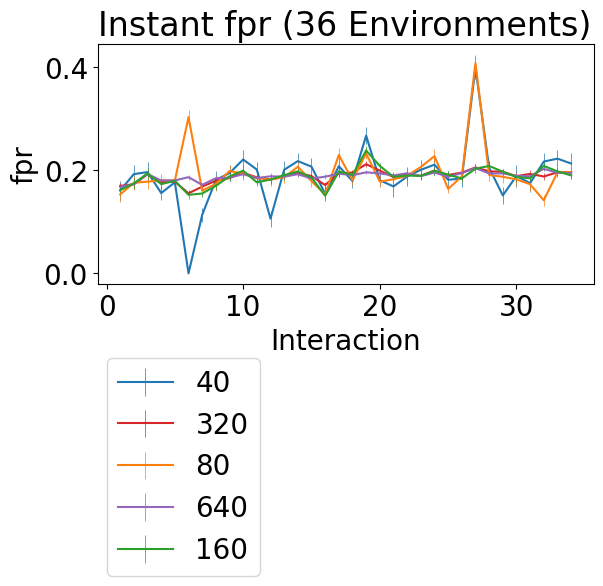

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted, n, seed = 1):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted
        
        self.n = n
        self.seed = seed

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'n': n, 'seed': seed }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(tp,fp,tn,fn):
            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)
            return {
                'tp':tp,
                'fp':fp,
                'tn':tn,
                'fn':fn,
                'tpn':tp/(tp+fp+tn+fn),
                'fpn':fp/(tp+fp+tn+fn),
                'tnn':tn/(tp+fp+tn+fn),
                'fnn':fn/(tp+fp+tn+fn),
                'f1':2*tp/(2*tp+fp+fn),
                'acc':(tp+tn)/(tp+fp+fn+tn),
                'plr':tpr/(fpr or 1),
                'pr' :tp/(fp or 1),
                'fpr':fp/((tn+fp) or 1),
                'fnr':fn/((tp+fn) or 1),
                'tpr':tp/((tp+fn) or 1), #sensitivity, recall
                'tnr':tn/((tn+fp) or 1), #specificity
                'ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                'npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                'bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            confs = []
            for j in range(self.n):

                rng = cb.CobaRandom(seed=j+env.params['rng'])
                rng_indexes = rng.shuffle(range(len(X0)))

                X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                lrn_ = deepcopy(lrn)

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,1)

                lrn_.set_s(env.params['rng']+j)
                lrn_.set_t(0)

                mems = []
                bits = []

                confs.append([])
                for i in range(min([len(Y0),45])):

                    a,p,y = None,None,None

                    with torch.no_grad():
                        x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                        x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                        x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                        y     = y2
                        a,p,o = lrn_.predict(x0,x1,x2)
                        bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                        mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                    if self.learn : bits.append(bit)
                    if self.replay: mems.append((mem,self.pers_mem_rpt))

                    if self.replay and len(mems) >= self.pers_mem_cnt:
                        rng.shuffle(mems, inplace=True)
                        for j in reversed(range(self.pers_mem_rcl)):
                            if j >= len(mems): continue
                            mem,n = mems[j]
                            bits.append(mem)
                            if n == 1: mems.pop(j)
                            else: mems[j] = [mem,n-1]

                    if self.learn and len(bits) >= self.pers_lrn_cnt:
                        for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                            lrn_.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                        del bits[:self.pers_lrn_cnt]

                    tp = int(a==send and y==1)
                    fp = int(a==send and y==0)
                    tn = int(a!=send and y==0)
                    fn = int(a!=send and y==1)

                    confs[-1].append([tp,fp,tn,fn])

            yield from (get_score(*map(sum,zip(*c))) for c in zip(*confs))

        yield from get_scores(env)

def sqrt_t(t):
    return .25*t**(1/2)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

envs = [ MyEnvironment(a0,a1,a2,[g],rng) for g in testable_G for rng in range(1) ]
lrns = [
    Method3(VWL("--loss_function logistic --quiet --coin"), 1, sqrt_t, seed=1),
]

vals = [
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [],40),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [],80),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [],160),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [],320),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [],640),
]

#The larger the number of resamples in the evaluator the better.
#In the plot below we see large spikes when sampling is 40 or 80
#and we still see medium spikes for red and green around x=18.

res = cb.Experiment(envs,lrns,vals).run(processes=32,quiet=True) #type: ignore
res.plot_learners(y='fpr',span=1,l=['learner_id','evaluator_id'],err='se',out=None, labels=['40','80','160','320','640'])



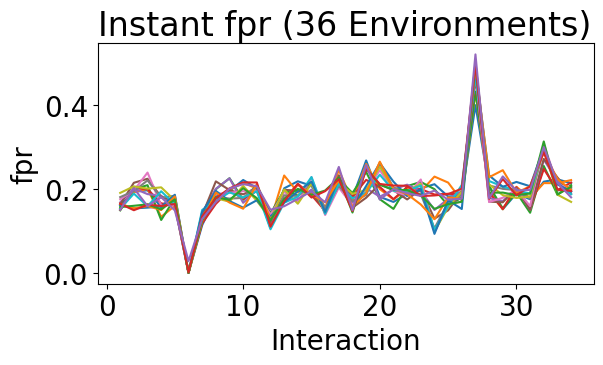

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted, n, seed = 1):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted
        
        self.n = n
        self.seed = seed

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'n': n, 'seed': seed }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(tp,fp,tn,fn):
            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)
            return {
                'tp':tp,
                'fp':fp,
                'tn':tn,
                'fn':fn,
                'tpn':tp/(tp+fp+tn+fn),
                'fpn':fp/(tp+fp+tn+fn),
                'tnn':tn/(tp+fp+tn+fn),
                'fnn':fn/(tp+fp+tn+fn),
                'f1':2*tp/(2*tp+fp+fn),
                'acc':(tp+tn)/(tp+fp+fn+tn),
                'plr':tpr/(fpr or 1),
                'pr' :tp/(fp or 1),
                'fpr':fp/((tn+fp) or 1),
                'fnr':fn/((tp+fn) or 1),
                'tpr':tp/((tp+fn) or 1), #sensitivity, recall
                'tnr':tn/((tn+fp) or 1), #specificity
                'ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                'npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                'bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            confs = []
            for j in range(self.n):

                rng = cb.CobaRandom(seed=j+env.params['rng'])
                rng_indexes = rng.shuffle(range(len(X0)))

                X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                lrn_ = deepcopy(lrn)

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,1)

                lrn_.set_s(env.params['rng']+j)
                lrn_.set_t(0)

                mems = []
                bits = []

                confs.append([])
                for i in range(min([len(Y0),45])):

                    a,p,y = None,None,None

                    with torch.no_grad():
                        x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                        x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                        x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                        y     = y2
                        a,p,o = lrn_.predict(x0,x1,x2)
                        bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                        mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                    if self.learn : bits.append(bit)
                    if self.replay: mems.append((mem,self.pers_mem_rpt))

                    if self.replay and len(mems) >= self.pers_mem_cnt:
                        rng.shuffle(mems, inplace=True)
                        for j in reversed(range(self.pers_mem_rcl)):
                            if j >= len(mems): continue
                            mem,n = mems[j]
                            bits.append(mem)
                            if n == 1: mems.pop(j)
                            else: mems[j] = [mem,n-1]

                    if self.learn and len(bits) >= self.pers_lrn_cnt:
                        for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                            lrn_.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                        del bits[:self.pers_lrn_cnt]

                    tp = int(a==send and y==1)
                    fp = int(a==send and y==0)
                    tn = int(a!=send and y==0)
                    fn = int(a!=send and y==1)

                    confs[-1].append([tp,fp,tn,fn])

            yield from (get_score(*map(sum,zip(*c))) for c in zip(*confs))

        yield from get_scores(env)

def sqrt_t(t):
    return .25*t**(1/2)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

envs = [ MyEnvironment(a0,a1,a2,[g],rng) for g in testable_G for rng in range(15) ]
lrns = [
    Method3(VWL("--loss_function logistic --quiet --coin"), 1, sqrt_t, seed=1),
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [],40),
]

#Shuffling the order of training examples within environments takes a long time
#but does relatively little to reduce extreme outliers in our performance metrics.
#clearly the performance across different ordering seeds is highly correlated.

res = cb.Experiment(envs,lrns,vals).run(processes=32,quiet=True) #type: ignore
for i in range(15):
    res.where(rng=i).plot_learners(y='fpr',span=1,l=['learner_id','evaluator_id'],out=None,colors=i,legend=False)


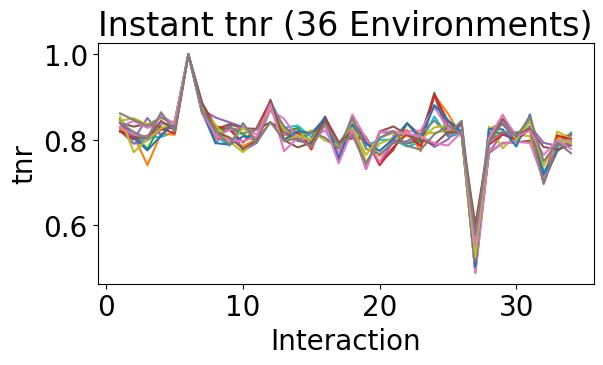

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted, n, seed = 1):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted
        
        self.n = n
        self.seed = seed

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'n': n, 'seed': seed }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(tp,fp,tn,fn):
            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)
            return {
                'tp':tp,
                'fp':fp,
                'tn':tn,
                'fn':fn,
                'tpn':tp/(tp+fp+tn+fn),
                'fpn':fp/(tp+fp+tn+fn),
                'tnn':tn/(tp+fp+tn+fn),
                'fnn':fn/(tp+fp+tn+fn),
                'f1':2*tp/(2*tp+fp+fn),
                'acc':(tp+tn)/(tp+fp+fn+tn),
                'plr':tpr/(fpr or 1),
                'pr' :tp/(fp or 1),
                'fpr':fp/((tn+fp) or 1),
                'fnr':fn/((tp+fn) or 1),
                'tpr':tp/((tp+fn) or 1), #sensitivity, recall
                'tnr':tn/((tn+fp) or 1), #specificity
                'ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                'npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                'bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            confs = []
            for j in range(self.n):

                rng = cb.CobaRandom(seed=j+env.params['rng'])
                rng_indexes = rng.shuffle(range(len(X0)))

                X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                lrn_ = deepcopy(lrn)

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,1)

                lrn_.set_s(env.params['rng']+j)
                lrn_.set_t(0)

                mems = []
                bits = []

                confs.append([])
                for i in range(min([len(Y0),45])):

                    a,p,y = None,None,None

                    with torch.no_grad():
                        x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                        x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                        x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                        y     = y2
                        a,p,o = lrn_.predict(x0,x1,x2)
                        bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                        mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                    if self.learn : bits.append(bit)
                    if self.replay: mems.append((mem,self.pers_mem_rpt))

                    if self.replay and len(mems) >= self.pers_mem_cnt:
                        rng.shuffle(mems, inplace=True)
                        for j in reversed(range(self.pers_mem_rcl)):
                            if j >= len(mems): continue
                            mem,n = mems[j]
                            bits.append(mem)
                            if n == 1: mems.pop(j)
                            else: mems[j] = [mem,n-1]

                    if self.learn and len(bits) >= self.pers_lrn_cnt:
                        for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                            lrn_.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                        del bits[:self.pers_lrn_cnt]

                    tp = int(a==send and y==1)
                    fp = int(a==send and y==0)
                    tn = int(a!=send and y==0)
                    fn = int(a!=send and y==1)

                    confs[-1].append([tp,fp,tn,fn])

            yield from (get_score(*map(sum,zip(*c))) for c in zip(*confs))

        yield from get_scores(env)

def sqrt_t(t):
    return .25*t**(1/2)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

envs = [ MyEnvironment(a0,a1,a2,[g],rng) for g in testable_G for rng in range(1) ]
lrns = [
    Method3(VWL("--loss_function logistic --quiet --coin"), 1, sqrt_t, seed=s) for s in range(15)
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [],40),
]

#Changing the seed for learners also doesn't seem to greatly reduce outliers
#in my performance metrics. 

res = cb.Experiment(envs,lrns,vals).run(processes=32,quiet=True) #type: ignore
res.plot_learners(y='tnr',span=1,l=['learner_id'],out=None,colors=i,legend=False)


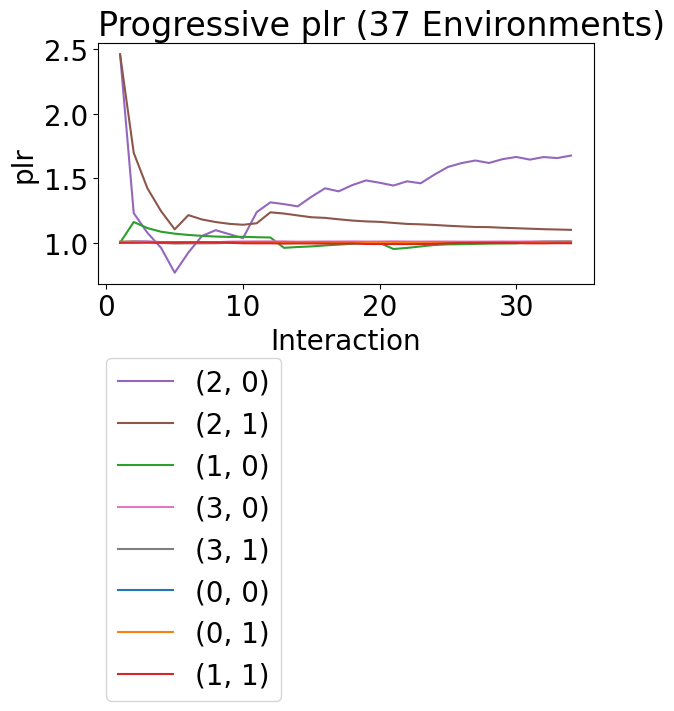

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted, n, seed = 1):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted
        
        self.n = n
        self.seed = seed

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'n': n, 'seed': seed }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(tp,fp,tn,fn):
            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)
            return {
                'tp':tp,
                'fp':fp,
                'tn':tn,
                'fn':fn,
                'tpn':tp/(tp+fp+tn+fn),
                'fpn':fp/(tp+fp+tn+fn),
                'tnn':tn/(tp+fp+tn+fn),
                'fnn':fn/(tp+fp+tn+fn),
                'f1':2*tp/(2*tp+fp+fn),
                'acc':(tp+tn)/(tp+fp+fn+tn),
                'plr':tpr/(fpr or 1),
                'pr' :tp/(fp or 1),
                'fpr':fp/((tn+fp) or 1),
                'fnr':fn/((tp+fn) or 1),
                'tpr':tp/((tp+fn) or 1), #sensitivity, recall
                'tnr':tn/((tn+fp) or 1), #specificity
                'ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                'npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                'bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            confs = []
            for j in range(self.n):

                rng = cb.CobaRandom(seed=j+env.params['rng'])
                rng_indexes = rng.shuffle(range(len(X0)))

                X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                lrn_ = deepcopy(lrn)

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,1)

                lrn_.set_s(env.params['rng']+j)
                lrn_.set_t(0)

                mems = []
                bits = []

                confs.append([])
                for i in range(min([len(Y0),45])):

                    a,p,y = None,None,None

                    with torch.no_grad():
                        x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                        x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                        x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                        y     = y2
                        a,p,o = lrn_.predict(x0,x1,x2)
                        bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                        mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                    if self.learn : bits.append(bit)
                    if self.replay: mems.append((mem,self.pers_mem_rpt))

                    if self.replay and len(mems) >= self.pers_mem_cnt:
                        rng.shuffle(mems, inplace=True)
                        for j in reversed(range(self.pers_mem_rcl)):
                            if j >= len(mems): continue
                            mem,n = mems[j]
                            bits.append(mem)
                            if n == 1: mems.pop(j)
                            else: mems[j] = [mem,n-1]

                    if self.learn and len(bits) >= self.pers_lrn_cnt:
                        for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                            lrn_.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                        del bits[:self.pers_lrn_cnt]

                    tp = int(a==send and y==1)
                    fp = int(a==send and y==0)
                    tn = int(a!=send and y==0)
                    fn = int(a!=send and y==1)

                    confs[-1].append([tp,fp,tn,fn])

            yield from (get_score(*map(sum,zip(*c))) for c in zip(*confs))

        yield from get_scores(env)

def sqrt_t(t):
    return .25*t**(1/2)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

envs = [ MyEnvironment(a0,a1,a2,[g],rng) for g in testable_G for rng in range(1) ]
lrns = [
    MethodR(),
    Method0(cb.VowpalCoverLearner(features=["a","ax"])),
    Method1(SquareCB(VWR("--loss_function logistic --quiet --coin"), 1, sqrt_t)), #current best
    Method3(VWL("--loss_function logistic --quiet --coin"), 1, sqrt_t),
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [],4000),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 3, 2, 2, 2, [],4000),
]

#Method1 and Evaluator0 seem to be the best performing but it isn't entirely clear that the 
#personalizer isn't hurting given that index=1 is peak performance. This is likely a red herring
#though because index=1 is not averaged with any other index.

res = cb.Experiment(envs,lrns,vals).run('../logs/4/test3.log.gz',processes=32,quiet=True) #type: ignore
res.plot_learners(y="plr",span=None,l=["learner_id","evaluator_id"],p=["g"])


In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(tp,fp,tn,fn):
            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert tp+fp+tn+fn != 0

            return {
                'tp':tp,
                'fp':fp,
                'tn':tn,
                'fn':fn,
                'tpn':tp/(tp+fp+tn+fn),
                'fpn':fp/(tp+fp+tn+fn),
                'tnn':tn/(tp+fp+tn+fn),
                'fnn':fn/(tp+fp+tn+fn),
                'f1':2*tp/((2*tp+fp+fn) or 1),
                'acc':(tp+tn)/(tp+fp+fn+tn),
                'plr':tpr/(fpr or 1),
                'pr' :tp/(fp or 1),
                'fpr':fp/((tn+fp) or 1),
                'fnr':fn/((tp+fn) or 1),
                'tpr':tp/((tp+fn) or 1), #sensitivity, recall
                'tnr':tn/((tn+fp) or 1), #specificity
                'ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                'npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                'bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                'snd': tp+fp,
                'sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),45])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn : bits.append(bit)
                        if self.replay: mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(self.pers_mem_rcl)):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = int(a==send and y==1)
                        fp = int(a==send and y==0)
                        tn = int(a!=send and y==0)
                        fn = int(a!=send and y==1)

                        confs[-1].append([tp,fp,tn,fn])

            yield from (get_score(*map(sum,zip(*c))) for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

envs = [ MyEnvironment(a0,a1,a2,[g],rng) for g in testable_G for rng in range(1) ]
lrns = [
#    MethodR(),
#    Method0(cb.VowpalCoverLearner(features=["a","ax"])),
#    Method0(SquareCB(VWL("--loss_function logistic --quiet --coin"), 1, sqrt_t)),
#    Method0(GraphSquareCB(VWL("--loss_function logistic --quiet --coin"), 1, sqrt_t)),
#    Method1(SquareCB(VWL("--loss_function logistic --quiet --coin"), 1, sqrt_t)), #current best
#    Method2(VWL("--loss_function logistic --quiet --coin"),GraphSquareCB(VWL("--loss_function logistic --quiet --coin"), 1, sqrt_t)),
    #Method4(VWR("--coin --quiet"), 1, sqrt_t),
    #Method4(VWR("--quiet"), 1, sqrt_t),
    #Method3(VWL("--loss_function logistic --quiet"), 1, sqrt_t),
    #Method3(VWL("--loss_function logistic --quiet --coin"), 1, sqrt_t),
#    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=0, power_t=1/2, scale_t=5, mu=1),
#    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=0, power_t=1/2, scale_t=5, mu=2),
#    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=0, power_t=1/2, scale_t=5, mu=3),
#    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=0, power_t=1/2, scale_t=5, mu=4),
    #Method3(VWL("--loss_function logistic --quiet --coin --interactions xx"), 1, sqrt_t),
    #Method3(TL(FeedForward([90,1])), 1, sqrt_t),
]

for gamma, power_t, scale_t, mu, sendr in product([0,1,2],[.25,.5,.75],[.5,1,2,4,8],[1,2,3,4],[1,1.5]):
    lrns.append(Method3(VWL("--loss_function logistic --quiet --coin"), gamma=gamma, power_t=power_t, scale_t=scale_t, mu=mu, sendr=sendr))

vals = [
    # ssl (v=2) + basis

    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 0, 0, 0, 0, [4],10,10),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 1, 1, 1, [4],10,40),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',45,-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 1, 1, 1, [4],10,40),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 2, 2, 1, 1, 1, [],10,10),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 2, 2, 1, 1, 1, [4],10,10),
]

res = cb.Experiment(envs,lrns,vals).run('../logs/4/test6.log.gz',processes=37,quiet=True) #type: ignore
res.plot_learners(y="tpr",span=None,l=["learner_id","evaluator_id"],p=["g"])
res.plot_contrast((1,1),(1,20),l=['evaluator_id','index'],x='g',y="plr",span=None,p=["g"],xticks=None)
res.plot_contrast(0,1,x='g',y="plr",span=None,p=["g"],xticks=None)


We removed 28 learner evaluations because they were shorter than 150 interactions.


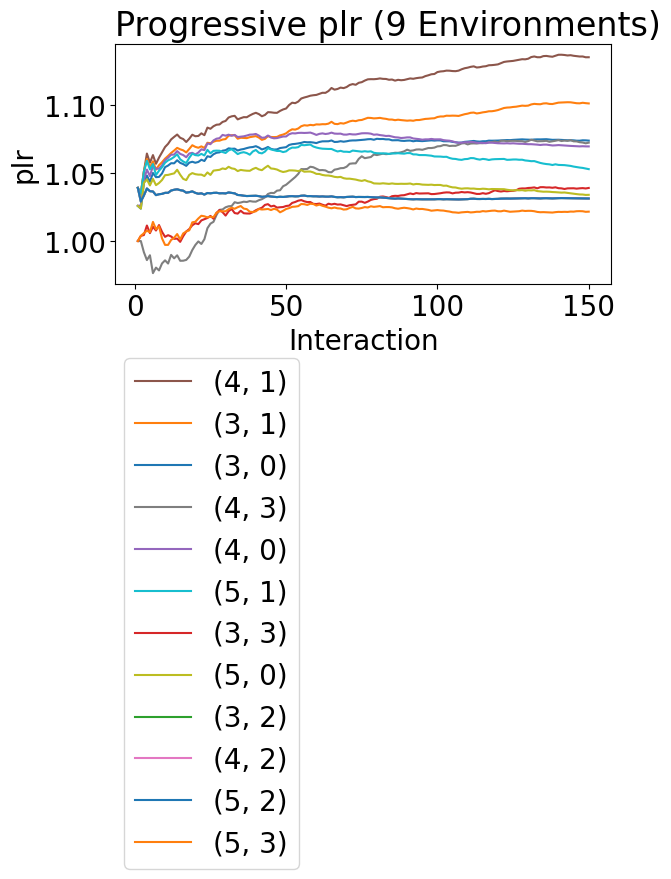

We removed 28 learner evaluations because they were shorter than 150 interactions.


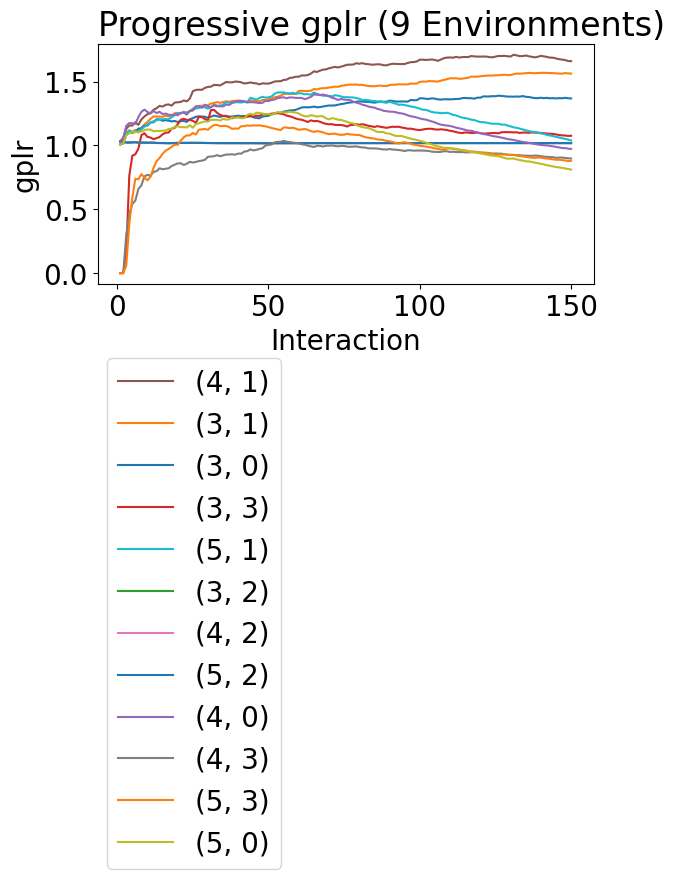

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn : bits.append(bit)
                        if self.replay: mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(self.pers_mem_rcl)):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs = [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(testable_G,4) for rng in range(1) ]
lrns = [
    MethodR(),
    MethodF([.25,.75]),
    MethodF([1,0]),
    #Method0(cb.VowpalCoverLearner(features=["a","ax"])),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5,sendonly=True),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5,testp=True),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5,posonly=True),
    #Method3(TL(FeedForward([90,1])), gamma=1, power_t=1/2, scale_t=5, mu=4),
]

vals = [
    # ssl (v=2) + basis
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',10,-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [ ], 2, 50),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [ ], 2, 50),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 0, 0, 0, 0, [ ], 2, 50),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 0, 1, 0, 0, 0, [ ], 2, 50),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',10,-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 0, 0, 0, 0, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 0, 1, 0, 0, 0, [4], 2, 100),
]

# We see four things below:
#   1) sendonly (4) improves our performance compared to (3) (which is good because we're getting more information, so the learner should be improving)
#   2) weighted [4] gives better performance than [ ] (these outcomes actually aren't below, but can be generated by uncommenting evaluators above)
#   3) having 90 features returned by the middle layer gives better performance than 10 features
#   4) using p when updating the online learner lowers performance (i.e., 3 vs 5 though on greedy performance there is no difference)
#   5) the greedy action shows much greater performance than the exploration choice, therefore we should probably increase gamma faster

# Questions unanswered:
    # are there better options for the number of features??
    # is it necessary to use federated learning or can we do one person personalization?
    # how should we tune the exploration rate to get more of the greedy performance?

span=None
#res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res.filter_fin(n=150).where(learner_id=[3,4,5]).plot_learners(y="plr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore
res.filter_fin(n=150).where(learner_id=[3,4,5]).plot_learners(y="gplr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore

We removed 20 learner evaluations because they were shorter than 150 interactions.


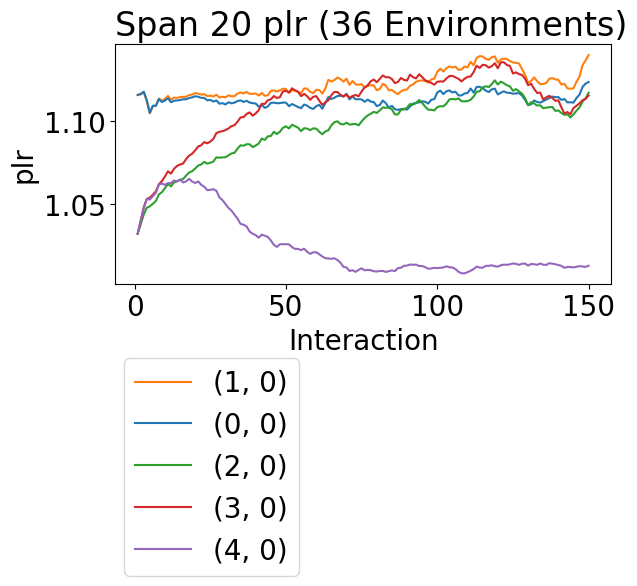

We removed 20 learner evaluations because they were shorter than 150 interactions.


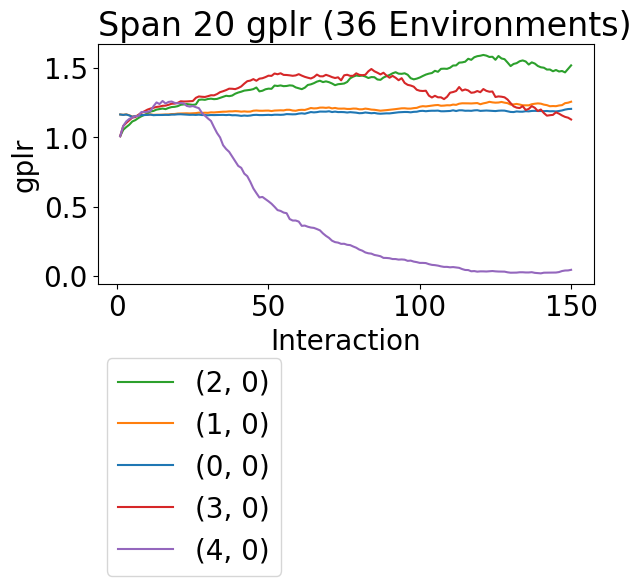

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn : bits.append(bit)
                        if self.replay: mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(self.pers_mem_rcl)):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs  = []
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]

lrns = [
    Method2(VWL("--loss_function logistic --quiet --coin"),GraphSquareCB(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5)),
    Method2(VWL("--loss_function logistic --quiet --coin"),GraphSquareCB(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),sendonly=True),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5,sendonly=True),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5,sendonly=True,testp=True),
]

vals = [
    # ssl (v=2) + basis
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',10,-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [ ], 2, 50),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [ ], 2, 50),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 0, 0, 0, 0, [ ], 2, 50),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 0, 1, 0, 0, 0, [ ], 2, 50),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',10,-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [4], 2, 100),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 0, 0, 0, 0, [4], 2, 100),
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',   -1), 0, 0, 120, 4, .5, 2, 4, 1, 0, 1, 0, 0, 0, [4], 2, 100),
]

# The plots below are interesting:
#   1) In this experiment we see that send every time eventually breaks down in the greedy case (3)... Adding in action probability doesn't fix the problem (4)

# This experiment leads to three questions:
#   1) Could improving the prediction features fix the collapse of performance when there are too many training examples? That is, could the learner find a solution
#      where it gets good at predicting no sends without losing performance among the sends.
#   2) Could using experience replay on only positive examples also fix the problem performance collapse due to overlearning on negative examples?
#   3) Could using individual personalized learning prevent the collapse with all send? This would be the case if the collapse is dues to learning from other individuals 
#      instead of learning a predictor that is good at predicting a single person.
#   4) Could residual learning starting from the warm-start model improve online learning performance?

span=20
res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res.filter_fin(n=150).plot_learners(y="plr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore
res.filter_fin(n=150).plot_learners(y="gplr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore

We removed 40 learner evaluations because they were shorter than 150 interactions.


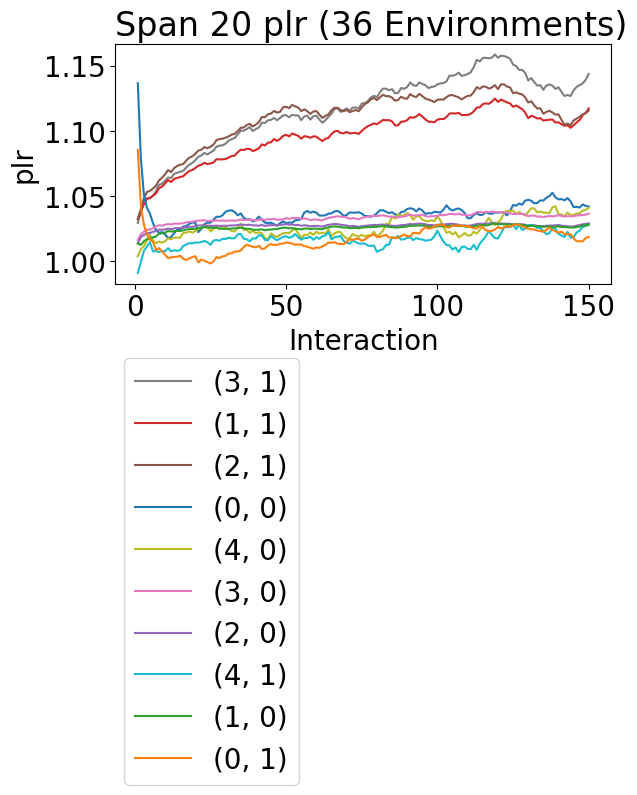

We removed 40 learner evaluations because they were shorter than 150 interactions.


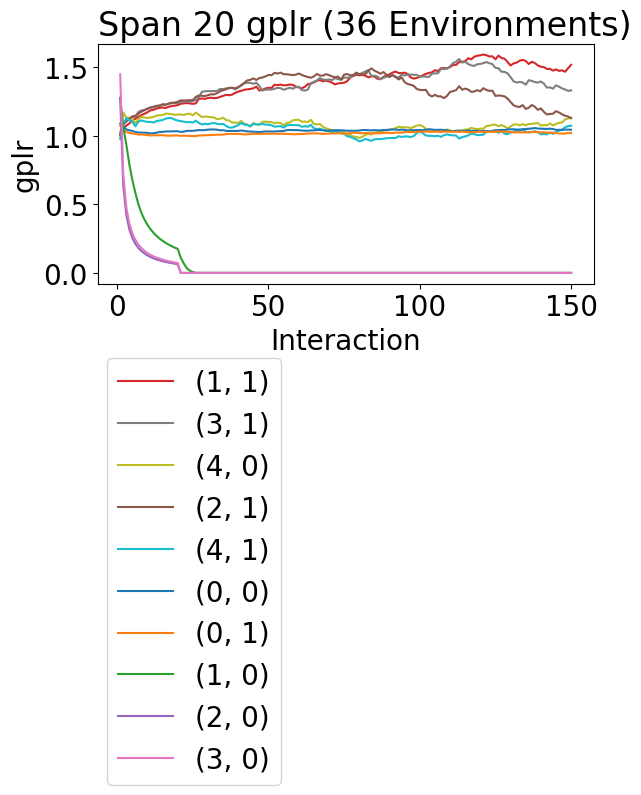

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn : bits.append(bit)
                        if self.replay: mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(self.pers_mem_rcl)):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs  = []
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]

lrns = [
    Method0(cb.VowpalCoverLearner(features=["a","ax","axx"])),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5,sendonly=True),
    Method3(VWL("--loss_function logistic --quiet --coin --interactions xx"), gamma=2, power_t=1/2, scale_t=5, mu=1.5,sendonly=True),
    Method3(TL(FeedForward([90,1])), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r', -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [ ], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r', -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [4], 2, 100),
]

# This experiment offers an response to:
#   Q) Could improving the prediction features fix the collapse of performance when there are too many training examples? That is, could the learner find a solution
#      where it gets good at predicting no sends without losing performance among the sends.
#   A) Adding more features doesn't prevent the performance collapse in only send, but it does seem to postpone it

span=20
res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res.filter_fin(n=150).plot_learners(y="plr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore
res.filter_fin(n=150).plot_learners(y="gplr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore

We removed 24 learner evaluations because they were shorter than 150 interactions.


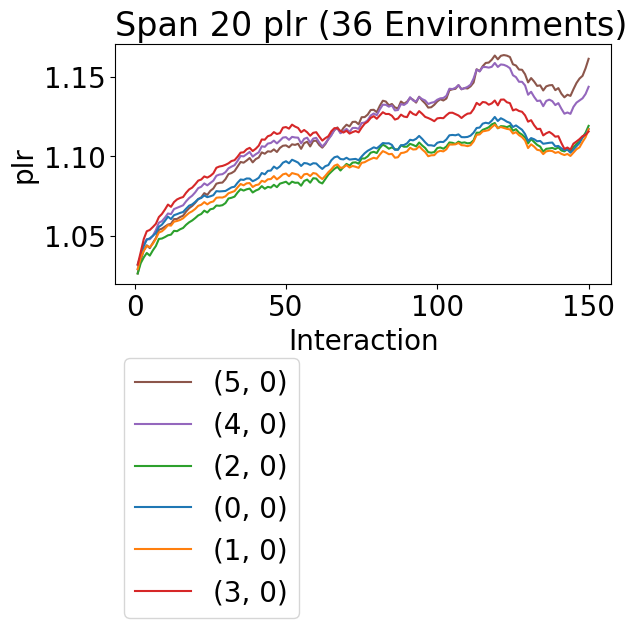

We removed 24 learner evaluations because they were shorter than 150 interactions.


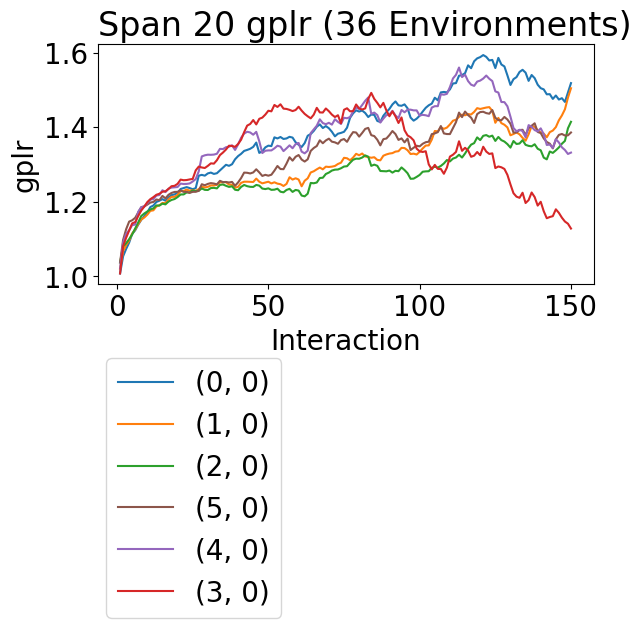

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn : bits.append(bit)
                        if self.replay: mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(self.pers_mem_rcl)):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs  = []
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]

lrns = [
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
    Method3(VWL("--loss_function logistic --quiet --coin --interactions xx"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
    Method3(VWL("--loss_function logistic --quiet --coin --interactions xx --interactions xxx"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5,sendonly=True),
    Method3(VWL("--loss_function logistic --quiet --coin --interactions xx"), gamma=2, power_t=1/2, scale_t=5, mu=1.5,sendonly=True),
    Method3(VWL("--loss_function logistic --quiet --coin --interactions xx --interactions xxx"), gamma=2, power_t=1/2, scale_t=5, mu=1.5,sendonly=True),
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r', -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, [4], 2, 100),
]

# This experiment offers an response to:
#   Q) Could improving the prediction features fix the collapse of performance when there are too many training examples? That is, could the learner find a solution
#      where it gets good at predicting no sends without losing performance among the sends.
#   A) Adding polynomial representation does seem to improve performance a little, but it doesn't solve the drop off problem when learning from every interaction,
#      it also doesn't seem to significantly improve in the case of limited interaction learning.

span=20
res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res.filter_fin(n=150).plot_learners(y="plr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore
res.filter_fin(n=150).plot_learners(y="gplr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore

We removed 16 learner evaluations because they were shorter than 150 interactions.


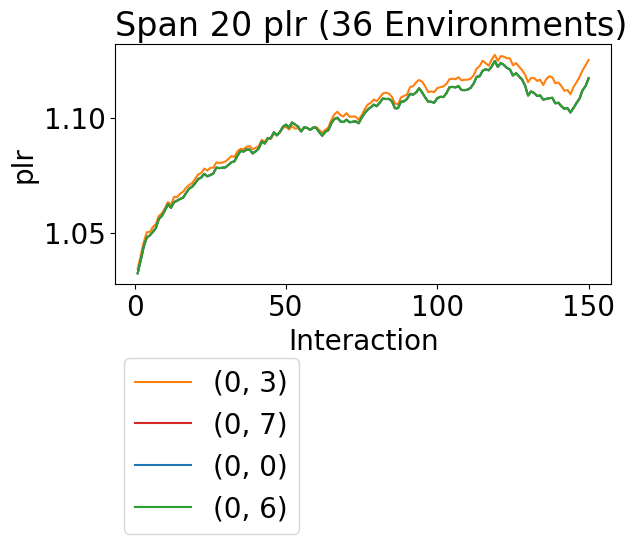

We removed 36 learner evaluations because they were shorter than 150 interactions.


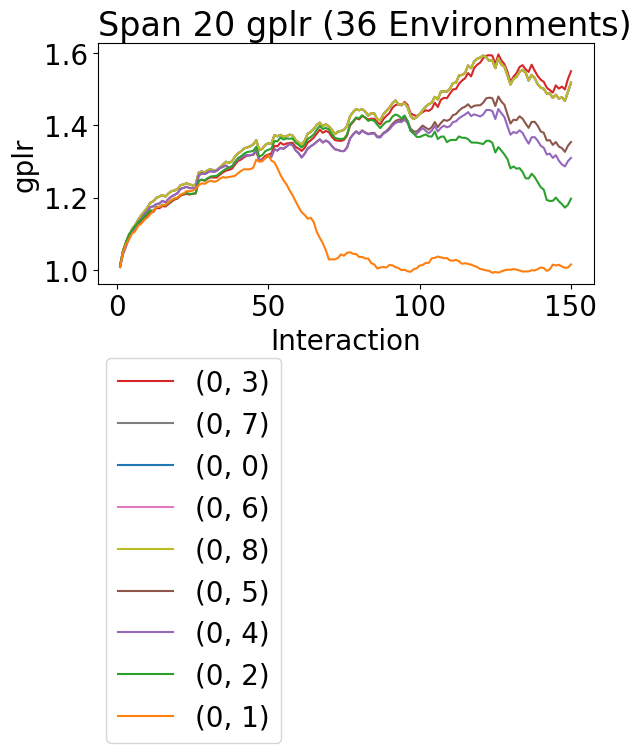

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_mem_pos, pers_mem_sep, pers_mem_snd, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_mem_sep = pers_mem_sep
        self.pers_mem_pos = pers_mem_pos
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.pers_mem_send = pers_mem_snd

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn  and (not self.pers_mem_send or a == send): bits.append(bit)
                        if self.replay and (not self.pers_mem_send or a == send) and (not self.pers_mem_pos or y==1): mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt and rng.random() < self.pers_mem_rcl:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(max(self.pers_mem_rcl,1))):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                if self.pers_mem_sep:
                                    x0,x1,x2,y0,y1,y2,a,p,o = mem
                                    lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                                else:
                                    bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs  = []
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]

lrns = [
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, False, False, False, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 50, 1, 1, False, False, False, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 50, 1, 1, False, False, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 50, 1, 1, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 50, 1, .1, False, False, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 50, 1, .1, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 50, 1, 1, True, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 50, 1, .1, True, False, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 50, 1, .1, True, True, True, [4], 2, 100),
]

#   Q) Could using experience replay on only positive examples also fix the problem performance collapse due to overlearning on negative examples?
#   A) Using memory can improve performance if done correctly. The most important thing is that learning from memory is a separate cadence from
#      online learning. Separating means that memory learning doesn't water down online learning. Once we separate memory learning from online 
#      learning, memory learning becomes helpful. This means that reducing the memory rate rate below 1 is no longer necessary to reduce memory harm.
#  
# Outstanding questions at this point:
#   1) Can the separate memory performance be improved?
#   2) Does positive only help. The above experiment didn't answer the question because we never reached enough positive memories to trigger memory learning.

span=20
#res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res.where(evaluator_id=[3,7,6,0]).filter_fin(n=150).plot_learners(y="plr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore
res.filter_fin(n=150).plot_learners(y="gplr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore

We removed 44 learner evaluations because they were shorter than 150 interactions.


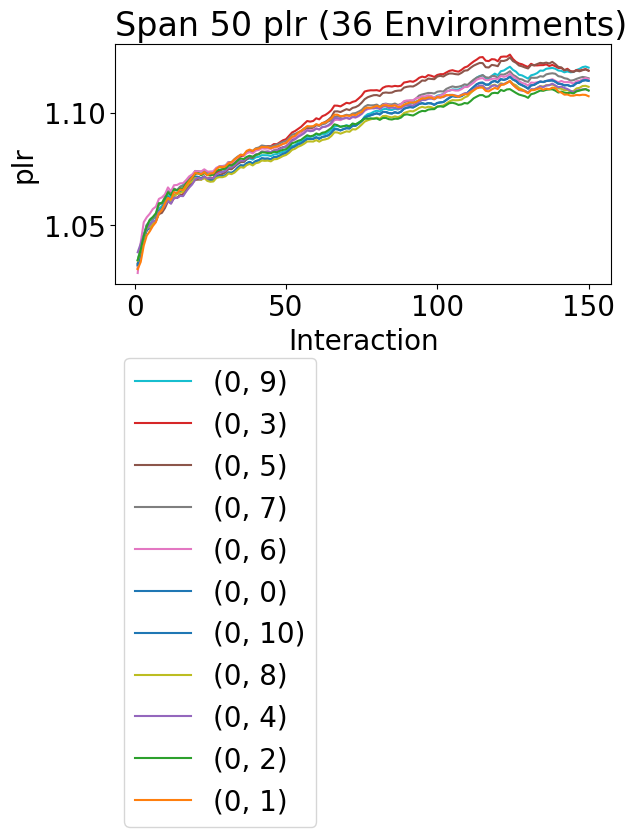

We removed 44 learner evaluations because they were shorter than 150 interactions.


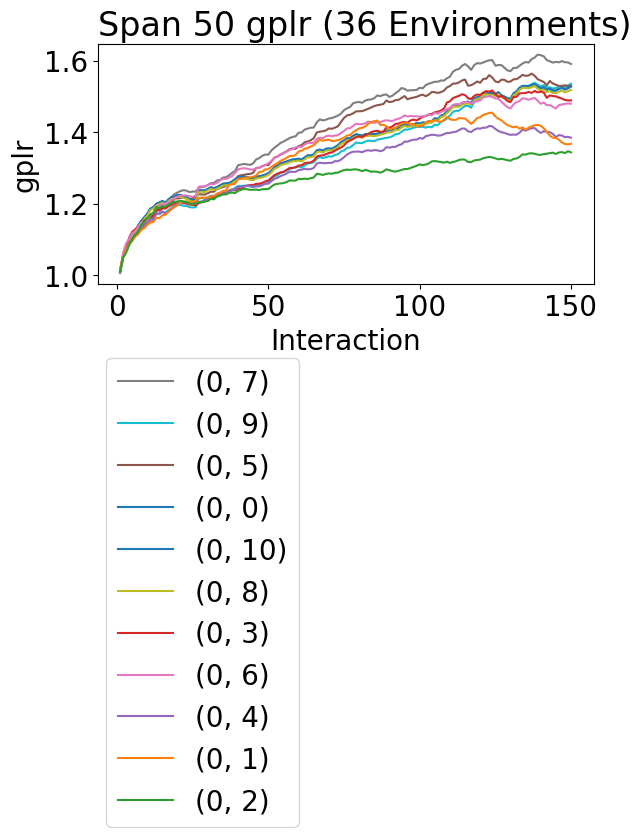

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_mem_pos, pers_mem_sep, pers_mem_snd, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_mem_sep = pers_mem_sep
        self.pers_mem_pos = pers_mem_pos
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.pers_mem_send = pers_mem_snd

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn  and (not self.pers_mem_send or a == send): bits.append(bit)
                        if self.replay and (not self.pers_mem_send or a == send) and (not self.pers_mem_pos or y==1): mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt and rng.random() < self.pers_mem_rcl:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(max(self.pers_mem_rcl,1))):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                if self.pers_mem_sep:
                                    x0,x1,x2,y0,y1,y2,a,p,o = mem
                                    lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                                else:
                                    bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs  = []
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]

lrns = [
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, False, False, False, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 5, 1, 1, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 5, 1, 1, True, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 10, 1, 1, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 10, 1, 1, True, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 15, 1, 1, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 15, 1, 1, True, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 30, 1, 1, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 30, 1, 1, True, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 50, 1, 1, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 50, 1, 1, True, True, True, [4], 2, 100),
]
 
# Outstanding questions at this point:
#   Q) Can the separate memory performance be improved?
#   A) The larger memory pools seems to give better performance in the long-term. This is likely due to the memories we learn from being less correlated
#      with online learning and so we don't get sucked into artificial local minimums in the solution space.
#
#   Q) Does positive only help. The above experiment didn't answer the question because we never reached enough positive memories to trigger memory learning.
#   A) No, we can say this pretty conclusively. The positive only memory all have even evaluator_ids which we see below are all much lower in performance.

span=50
res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res.filter_fin(n=150).plot_learners(y="plr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore
res.filter_fin(n=150).plot_learners(y="gplr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore

We removed 20 learner evaluations because they were shorter than 150 interactions.


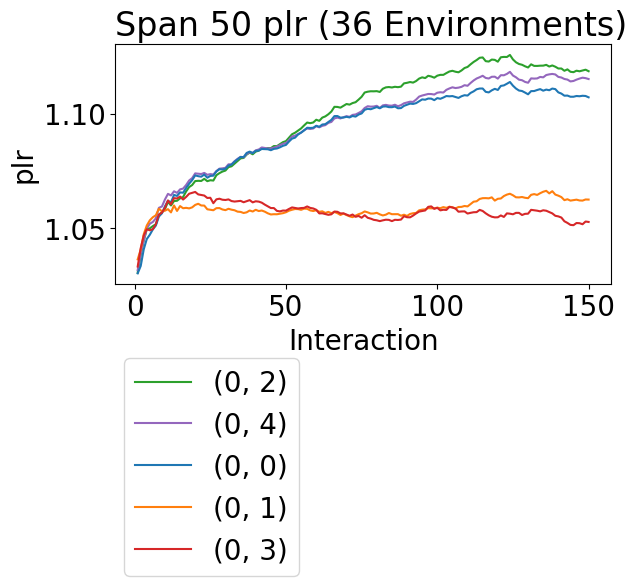

We removed 20 learner evaluations because they were shorter than 150 interactions.


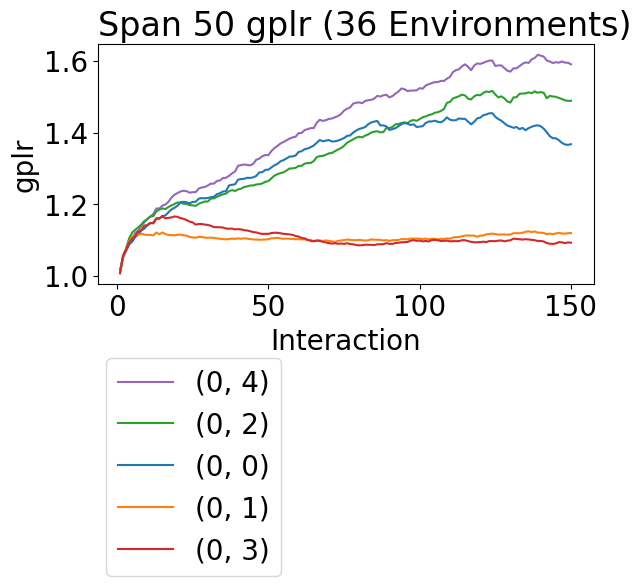

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_mem_pos, pers_mem_sep, pers_mem_snd, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_mem_sep = pers_mem_sep
        self.pers_mem_pos = pers_mem_pos
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.pers_mem_send = pers_mem_snd

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn  and (not self.pers_mem_send or a == send): bits.append(bit)
                        if self.replay and (not self.pers_mem_send or a == send) and (not self.pers_mem_pos or y==1): mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt and rng.random() < self.pers_mem_rcl:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(max(self.pers_mem_rcl,1))):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                if self.pers_mem_sep:
                                    x0,x1,x2,y0,y1,y2,a,p,o = mem
                                    lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                                else:
                                    bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs  = []
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]

lrns = [
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 5, 1, 1, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 5, 1, .5, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 10, 1, 1, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 10, 1, .5, False, True, True, [4], 2, 100),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 30, 1, 1, False, True, True, [4], 2, 100),
]
 
# Outstanding questions at this point:
#   Q) Can the separate memory performance be improved?
#   A) It seems pretty clear at this point that the separate memory that starts at 30 is the best

span=50
res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res.filter_fin(n=150).plot_learners(y="plr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore
res.filter_fin(n=150).plot_learners(y="gplr",span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore

We removed 56 learner evaluations because they were shorter than 40 interactions.
We shortened 324 learner evaluations because they were longer than the shortest environment.
We removed 2 ['g'] because more than one existed for each ['learner_id', 'evaluator_id'].


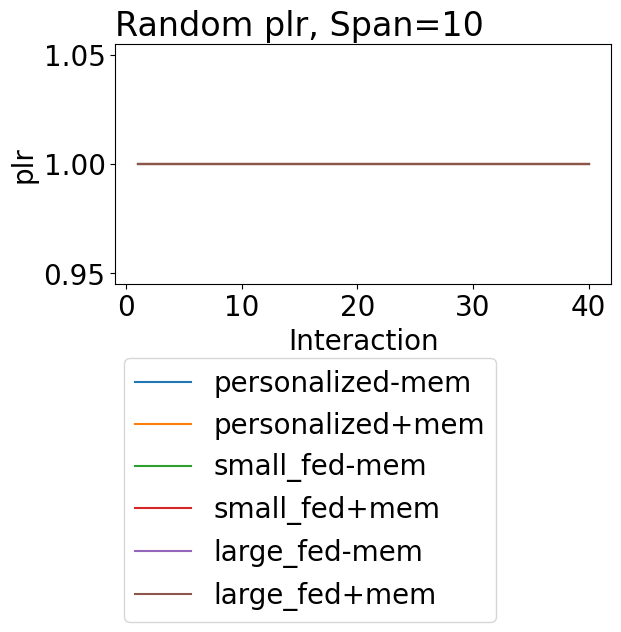

We removed 2 ['g'] because more than one existed for each ['learner_id', 'evaluator_id'].


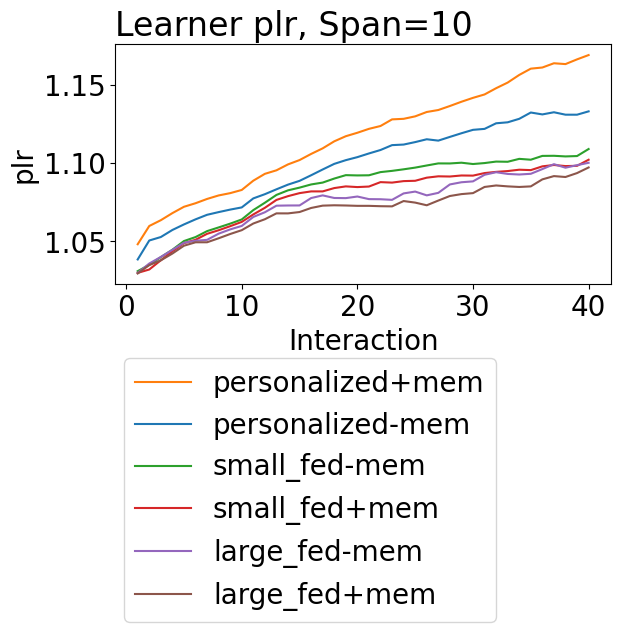

We removed 2 ['g'] because more than one existed for each ['learner_id', 'evaluator_id'].


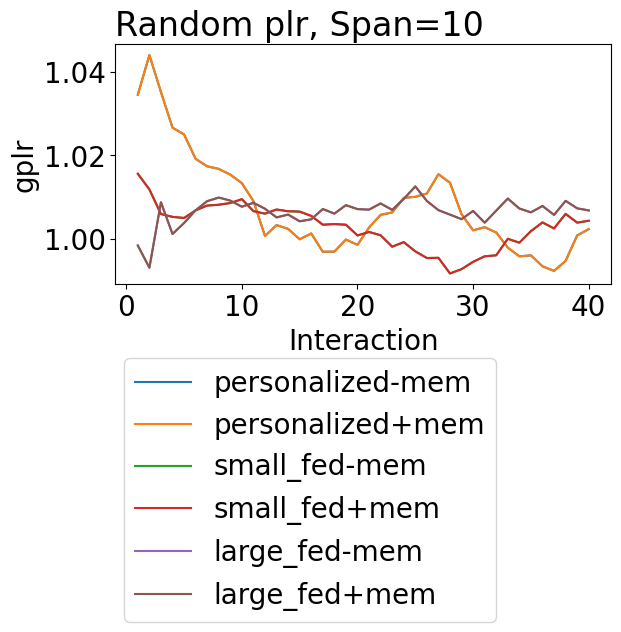

We removed 2 ['g'] because more than one existed for each ['learner_id', 'evaluator_id'].


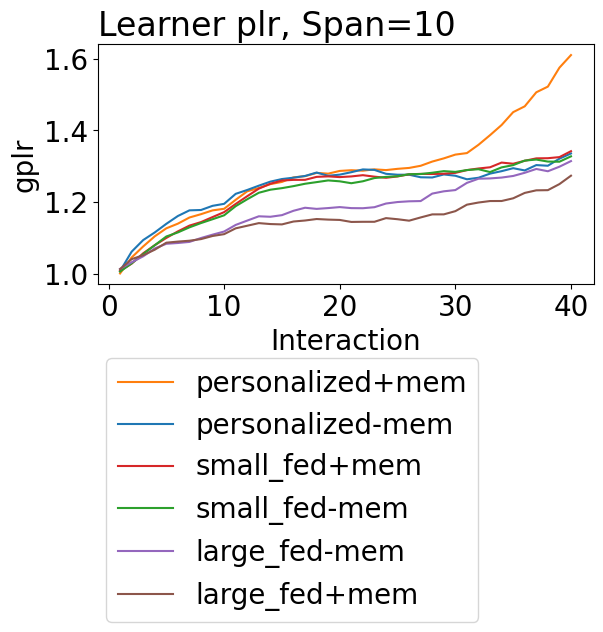

In [274]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_mem_pos, pers_mem_sep, pers_mem_snd, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_mem_sep = pers_mem_sep
        self.pers_mem_pos = pers_mem_pos
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.pers_mem_send = pers_mem_snd

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn  and (not self.pers_mem_send or a == send): bits.append(bit)
                        if self.replay and (not self.pers_mem_send or a == send) and (not self.pers_mem_pos or y==1): mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt and rng.random() < self.pers_mem_rcl:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(max(self.pers_mem_rcl,1))):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                if self.pers_mem_sep:
                                    x0,x1,x2,y0,y1,y2,a,p,o = mem
                                    lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                                else:
                                    bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs  = []
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),1) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),2) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),2) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),4) for rng in range(1) ]

lrns = [
    MethodR(),
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5),
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, False, True, True, [4], 4, 200),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 15, 1, 1, False, True, True, [4], 4, 200),
]

#   Q) Could using individual personalized learning improve performance?
#   A) Yes, personalized learning with a small amount of experience replay greatly improves PLR performance.

#   4) Could residual learning starting from the warm-start model improve online learning performance?


y="plr"
span=10
#res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res_ = res.filter_fin(n=40)
for y_ in [y,f"g{y}"]:
    res_.where(learner_id=0).filter_env(lambda x: len(x[2])==1).filter_fin(n=40).plot_learners(y=y_,span=span,l=["learner_id","evaluator_id"],p=["g"],colors=0,labels=["personalized-mem","personalized+mem"],out=None) #type: ignore
    res_.where(learner_id=0).filter_env(lambda x: len(x[2])==2).filter_fin(n=40).plot_learners(y=y_,span=span,l=["learner_id","evaluator_id"],p=["g"],colors=2,labels=["small_fed-mem","small_fed+mem"],out=None)
    res_.where(learner_id=0).filter_env(lambda x: len(x[2])==4).filter_fin(n=40).plot_learners(y=y_,span=span,l=["learner_id","evaluator_id"],p=["g"],colors=4,labels=["large_fed-mem","large_fed+mem"],title=f"Random {y}, Span={span}")
    res_.where(learner_id=1).filter_env(lambda x: len(x[2])==1).filter_fin(n=40).plot_learners(y=y_,span=span,l=["learner_id","evaluator_id"],p=["g"],colors=0,labels=["personalized-mem","personalized+mem"],out=None) #type: ignore
    res_.where(learner_id=1).filter_env(lambda x: len(x[2])==2).filter_fin(n=40).plot_learners(y=y_,span=span,l=["learner_id","evaluator_id"],p=["g"],colors=2,labels=["small_fed-mem","small_fed+mem"],out=None)
    res_.where(learner_id=1).filter_env(lambda x: len(x[2])==4).filter_fin(n=40).plot_learners(y=y_,span=span,l=["learner_id","evaluator_id"],p=["g"],colors=4,labels=["large_fed-mem","large_fed+mem"],title=f"Learner {y}, Span={span}")


We removed 36 learner evaluations because they were shorter than 40 interactions.
We shortened 75 learner evaluations because they were longer than the shortest environment.


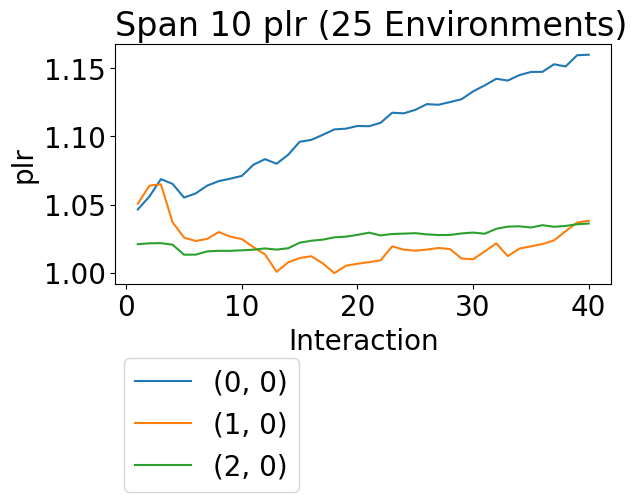

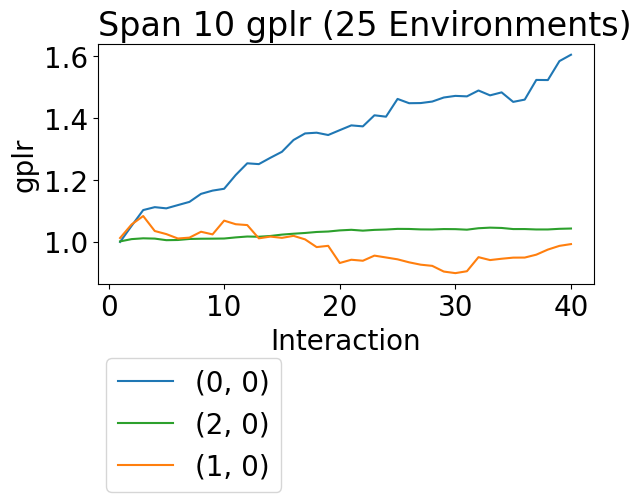

In [ ]:
class VWL2:
    def __init__(self, args):
        self._args = args
        self.params = {'vwl_args':args}
        self.vw_warm = cb.VowpalMediator()
        self.vw_test = cb.VowpalMediator()
        self.state   = "testing"
        assert "logistic" in args
    def warming(self):
        self.state = 'warming'
    def testing(self):
        self.state = 'testing'
    def predict(self, features):
        if not self.vw_warm.is_initialized: self.vw_warm.init_learner(self._args, 1)
        if not self.vw_test.is_initialized: self.vw_test.init_learner(self._args, 1)
        base = self.vw_warm.predict(self.vw_warm.make_example({"x":features})) #type: ignore
        return 1/(1+np.exp(-(base+self.vw_test.predict(self.vw_test.make_example({"x":features}))))) #type: ignore
    def learn(self, features, value, prob):
        if not self.vw_warm.is_initialized: self.vw_warm.init_learner(self._args, 1)
        if not self.vw_test.is_initialized: self.vw_test.init_learner(self._args, 1)
        assert value in [0,1]
        value = -1 if value == 0 else 1
        if self.state == "warming":    
            self.vw_warm.learn(self.vw_warm.make_example({"x":features}, f"{value} {1/prob}")) #type: ignore
        if self.state == "testing":
            base = self.vw_warm.predict(self.vw_warm.make_example({"x":features})) #type: ignore
            self.vw_test.learn(self.vw_test.make_example({"x":features}, f"{value} {1/prob} {base}")) #type: ignore

class VWL3:
    def __init__(self, args):
        self._args = args
        self.params = {'vwl_args':args}
        self.vw_warm = cb.VowpalMediator()
        self.vw_test = cb.VowpalMediator()
        self.state   = "testing"
        assert "logistic" in args
    def warming(self):
        self.state = 'warming'
    def testing(self):
        self.state = 'testing'
    def predict(self, features):
        if not self.vw_warm.is_initialized: self.vw_warm.init_learner(self._args, 1)
        if not self.vw_test.is_initialized: self.vw_test.init_learner(self._args, 1)
        base = self.vw_warm.predict(self.vw_warm.make_example({"x":features})) #type: ignore
        pred = base+self.vw_test.predict(self.vw_test.make_example({"x":features}))
        return 1/(1+np.exp(-pred)) #type: ignore
    def learn(self, features, value, prob):
        if not self.vw_warm.is_initialized: self.vw_warm.init_learner(self._args, 1)
        if not self.vw_test.is_initialized: self.vw_test.init_learner(self._args, 1)
        assert value in [0,1]
        value = -1 if value == 0 else 1
        if self.state == "warming":    
            base = self.vw_warm.predict(self.vw_warm.make_example({"x":features})) #type: ignore
            self.vw_warm.learn(self.vw_warm.make_example({"x":features}, f"{value} {1/prob}")) #type: ignore
            self.vw_test.learn(self.vw_test.make_example({"x":features}, f"{value} {1/prob} {base}")) #type: ignore
        if self.state == "testing":
            base = self.vw_warm.predict(self.vw_warm.make_example({"x":features})) #type: ignore
            self.vw_test.learn(self.vw_test.make_example({"x":features}, f"{value} {1/prob} {base}")) #type: ignore

class VWL4:
    def __init__(self, args):
        self._args = args
        self.params = {'vwl_args':args}
        self.vw_warm = cb.VowpalMediator()
        self.vw_test = cb.VowpalMediator()
        self.state   = "testing"
        assert "logistic" in args
    def warming(self):
        self.state = 'warming'
    def testing(self):
        self.state = 'testing'
    def predict(self, features):
        if not self.vw_warm.is_initialized: self.vw_warm.init_learner(self._args, 1)
        if not self.vw_test.is_initialized: self.vw_test.init_learner(self._args, 1)
        base = self.vw_warm.predict(self.vw_warm.make_example({"x":features})) #type: ignore
        return 1/(1+np.exp(-(self.vw_test.predict(self.vw_test.make_example({"x":[base]+features}))))) #type: ignore
    def learn(self, features, value, prob):
        if not self.vw_warm.is_initialized: self.vw_warm.init_learner(self._args, 1)
        if not self.vw_test.is_initialized: self.vw_test.init_learner(self._args, 1)
        assert value in [0,1]
        value = -1 if value == 0 else 1
        if self.state == "warming":
            base = self.vw_warm.predict(self.vw_warm.make_example({"x":features})) #type: ignore
            self.vw_warm.learn(self.vw_warm.make_example({"x":features}, f"{value} {1/prob}")) #type: ignore
            self.vw_test.learn(self.vw_test.make_example({"x":[base]+features}, f"{value} {1/prob}")) #type: ignore
        if self.state == "testing":
            base = self.vw_warm.predict(self.vw_warm.make_example({"x":features})) #type: ignore
            self.vw_test.learn(self.vw_test.make_example({"x":[base]+features}, f"{value} {1/prob}")) #type: ignore

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_mem_pos, pers_mem_sep, pers_mem_snd, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_mem_sep = pers_mem_sep
        self.pers_mem_pos = pers_mem_pos
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.pers_mem_send = pers_mem_snd

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn  and (not self.pers_mem_send or a == send): bits.append(bit)
                        if self.replay and (not self.pers_mem_send or a == send) and (not self.pers_mem_pos or y==1): mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt and rng.random() < self.pers_mem_rcl:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(max(self.pers_mem_rcl,1))):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                if self.pers_mem_sep:
                                    x0,x1,x2,y0,y1,y2,a,p,o = mem
                                    lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                                else:
                                    bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs  = []
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),1) for rng in range(1) ]

lrns = [
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5), #type: ignore
    Method3(VWL2("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5), #type: ignore
    Method3(VWL3("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5), #type: ignore
    #Method3(VWL4("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5), #type: ignore
]

vals = [
    # ssl (v=2) + basis
    #MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 0, 0, 0, False, True, True, [4], 4, 50),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 15, 1, 1, False, True, True, [4], 4, 50),
]

#   Q) Could residual learning starting from the warm-start model improve online learning performance?
#   A) No, I can't get it to work, and I'm not really sure why...

res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res_ = res.filter_fin(n=40)

y,span="plr",10
for y_ in [y,f"g{y}"]:
    res_.plot_learners(y=y_,span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore


We removed 72 learner evaluations because they were shorter than 40 interactions.
We shortened 150 learner evaluations because they were longer than the shortest environment.


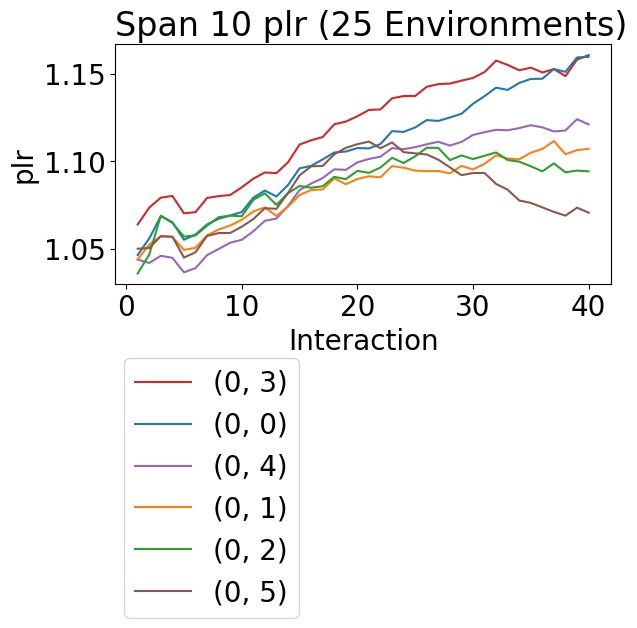

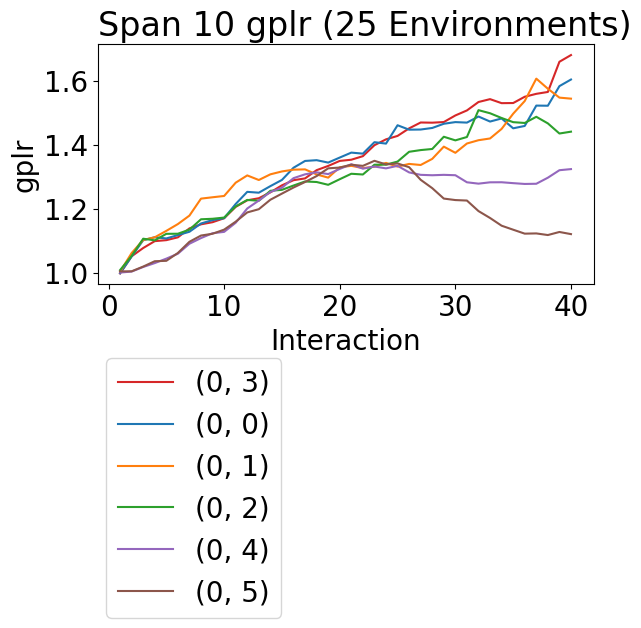

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_mem_pos, pers_mem_sep, pers_mem_snd, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_mem_sep = pers_mem_sep
        self.pers_mem_pos = pers_mem_pos
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.pers_mem_send = pers_mem_snd

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn  and (not self.pers_mem_send or a == send): bits.append(bit)
                        if self.replay and (not self.pers_mem_send or a == send) and (not self.pers_mem_pos or y==1): mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt and rng.random() < self.pers_mem_rcl:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(max(self.pers_mem_rcl,1))):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                if self.pers_mem_sep:
                                    x0,x1,x2,y0,y1,y2,a,p,o = mem
                                    lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                                else:
                                    bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs  = []
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),1) for rng in range(1) ]

lrns = [
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5), #type: ignore
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',    -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 15, 1, 1, False, True, True, [4], 4, 50),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',105,-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 15, 1, 1, False, True, True, [4], 4, 50),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',75, -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 15, 1, 1, False, True, True, [4], 4, 50),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',    -1), 0, 0, 120, 4, .5, 2, 4, 1, 2, 1, 15, 1, 1, False, True, True, [4], 4, 50),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',    -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 2, 15, 1, 1, False, True, True, [4], 4, 50),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',    -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 2, 15, 2, 2, False, True, True, [4], 4, 50),
]

#   Q) Can the hyperparameters be improved?
#   A) It looks like things are tuned fairly well. The best improvement I found was doing 2 warm-starting passes.

res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res_ = res.filter_fin(n=40)

y,span="plr",10
for y_ in [y,f"g{y}"]:
    res_.plot_learners(y=y_,span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore


We removed 48 learner evaluations because they were shorter than 40 interactions.
We shortened 100 learner evaluations because they were longer than the shortest environment.


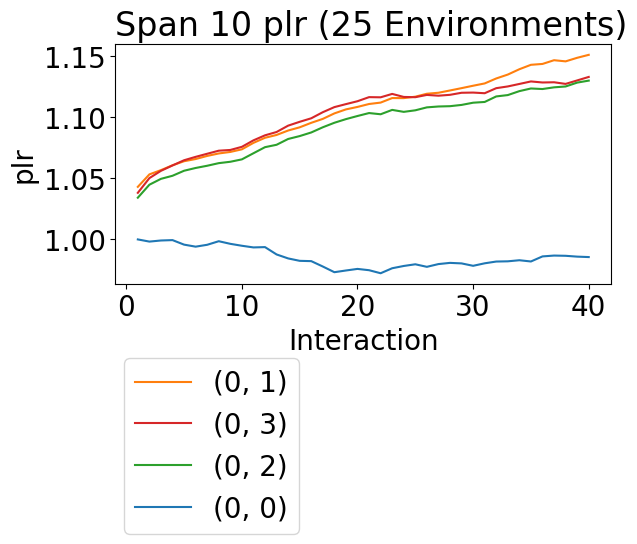

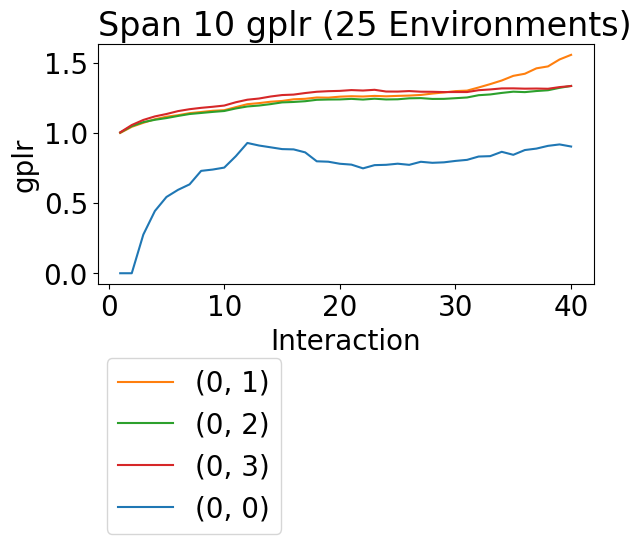

In [291]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a0, a1, a2, g, rng):
        self.params = {'trn0':a0, 'trn1':a1, 'trn2':a2, 'g':g, 'rng': rng}
        self.X0 = None
        self.X1 = None
        self.X2 = None
        self.Y  = None
        self.G  = None
        self.a0 = list(a0)
        self.a1 = list(a1)
        self.a2 = list(a2)
        self.g = g
        self.a0[7] = [a0[7],2,1,10] if a0[7] else None
        self.a1[7] = [a1[7],2,1,10] if a1[7] else None
        self.a2[7] = [a2[7],2,1,10] if a2[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X0 is not None: return self.X0,self.X1,self.X2,self.Y,self.G

        X0,Y,G = zip(*map(make_xyg2, work_items(*self.a0)))
        X1,Y,G = zip(*map(make_xyg2, work_items(*self.a1)))
        X2,Y,G = zip(*map(make_xyg2, work_items(*self.a2)))

        X0 = torch.tensor(list(it.chain.from_iterable(X0))).float()
        X1 = torch.tensor(list(it.chain.from_iterable(X1))).float()
        X2 = torch.tensor(list(it.chain.from_iterable(X2))).float()
        Y  = torch.tensor(list(it.chain.from_iterable(Y ))).float()
        G  = torch.tensor(list(it.chain.from_iterable(G ))).int()

        self.X0,self.X1,self.X2,self.Y,self.G = X0,X1,X2,Y,G

        if X0.shape[0] == 0: return

        all_na = torch.isnan(Y[:,[0,1]]).all(dim=1)
        X0 = X0[~all_na]
        X1 = X1[~all_na]
        X2 = X2[~all_na]
        Y  = Y[~all_na].float()
        G  = G[~all_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X0)))

        self.X0,self.X1,self.X2,self.Y,self.G = X0[rng_indexes],X1[rng_indexes],X2[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X0,self.X1,self.X2,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_mem_pos, pers_mem_sep, pers_mem_snd, weighted, outer, inner):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_mem_sep = pers_mem_sep
        self.pers_mem_pos = pers_mem_pos
        
        self.learn  = (pers_lrn_cnt > 0)
        self.replay = (pers_lrn_cnt > 0) and (pers_mem_cnt > 0)

        self.weighted = weighted

        self.outer = outer
        self.inner = inner

        self.pers_mem_send = pers_mem_snd

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted, 'test':(outer,inner) }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def replace_x(layers,n_feats,n_persons):
            new_layers = []
            for l in layers:
                if l == 'x': new_layers.append(n_feats)
                elif l == '-x': new_layers.append(n_feats*n_persons)
                elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l,n_feats,n_persons))
                else: new_layers.append(l)
            return new_layers

        def remove_na(X,Y,G=None):
            any_na = torch.isnan(Y)
            if Y.ndim==2: any_na = any_na.any(dim=1)
            if G == None: return X[~any_na],Y[~any_na]
            else: return X[~any_na],Y[~any_na],G[~any_na]

        def pretrain(trn_X,trn_Y,trn_G):
            n_feats = trn_X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = trn_Y.shape[1]

            _s1 = replace_x(self.s1,n_feats,n_persons)
            _s2 = replace_x(self.s2,n_feats,n_persons)
            _s3 = replace_x(self.s3,n_feats,n_persons)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            [s1,sa,s2,s3,sb] = mods
            [s1opt,saopt,s2opt,s3opt,sbopt] = opts

            if _s1 and self.dae_steps:
                opts = list(filter(None,[s1opt,saopt]))
                X,G,W = trn_X,trn_G,make_weights(trn_G)

                if _s1[-1] != n_feats*n_persons:
                    Z = X
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                    R = torch.arange(len(X)).unsqueeze(1)
                    Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                    Z[R,I] = X

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                loss = torch.nn.L1Loss()
                for _ in range(self.dae_steps):
                    for (_X,_z,_w) in torch_loader:
                        for o in opts: o.zero_grad()
                        loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                        for o in opts: o.step()

            if self.ssl_samps:
                X, Y, G = trn_X,trn_Y,trn_G

                if self.ssl_negs == 0: raise Exception("neg can't be 0")
                if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                ssl = sslv1 if self.ssl_v == 1 else sslv2

                for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                    torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = s2(s1(_A.nan_to_num()))
                        _P = s2(s1(_P.nan_to_num()))
                        _N = s2(s1(_N.nan_to_num()))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.ssl_tau)
                        n = torch.exp(n/self.ssl_tau)

                        if s2opt: s2opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if s2opt: s2opt.step()

            if self.ws_steps0:
                opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                for o in opts: o.zero_grad()

                X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                if _s3[-1] != n_tasks*n_persons:
                    Z = Y
                else:
                    i = defaultdict(lambda c= count(0):next(c))
                    I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                    R = torch.arange(len(Y)).unsqueeze(1)
                    Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                    Z[R,I] = Y

                torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                for _ in range(self.ws_steps0):
                    for _X,_z,_w in torch_loader:
                        for o in opts: o.zero_grad()
                        loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                        loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                        for o in opts: o.step()

            for m in mods: m.eval()

            return lambda x: s3(s2(s1(x.nan_to_num())))

        def get_score(c,s,l):
            C = list(map(sum,zip(*c)))
            tp,fp,tn,fn = C[s]

            tpr = tp/((tp+fn) or 1)
            fpr = fp/((tn+fp) or 1)

            assert abs(sum(C[:4]) - sum(C[4:])) < .0001, f"{sum(C[:4])} != {sum(C[4:])}"
            assert tp+fp+tn+fn != 0

            return {
                f'{l}tp':tp,
                f'{l}fp':fp,
                f'{l}tn':tn,
                f'{l}fn':fn,
                f'{l}tpn':tp/(tp+fp+tn+fn),
                f'{l}fpn':fp/(tp+fp+tn+fn),
                f'{l}tnn':tn/(tp+fp+tn+fn),
                f'{l}fnn':fn/(tp+fp+tn+fn),
                f'{l}f1':2*tp/((2*tp+fp+fn) or 1),
                f'{l}acc':(tp+tn)/(tp+fp+fn+tn),
                f'{l}plr':tpr/(fpr or 1),
                f'{l}pr' :tp/(fp or 1),
                f'{l}fpr':fp/((tn+fp) or 1), #probability of tn is predicted positive
                f'{l}fnr':fn/((tp+fn) or 1),
                f'{l}tpr':tp/((tp+fn) or 1), #sensitivity, recall
                f'{l}tnr':tn/((tn+fp) or 1), #specificity
                f'{l}ppv':tp/((tp+fp) or 1), #positive precision, positive predictive value
                f'{l}npv':tn/((tn+fn) or 1), #negative precision, negative predictive value
                f'{l}bac':(tp/((tp+fn) or 1) + tn/((tn+fp) or 1))/2,
                f'{l}snd': tp+fp,
                f'{l}sndn': (tp+fp)/(tp+fp+tn+fn)
            }

        def get_scores(env):
            from copy import deepcopy
            from statistics import mean

            X0,X1,X2,Y,G = env.get_data()

            g = env.g
            Y0 = Y[:,[0  ]]
            Y1 = Y[:,[  1]]
            Y2 = Y[:,[0,1]]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)

            if sum(is_tst) < 20: return

            trn_X0, trn_X1, trn_X2 = X0[is_trn], X1[is_trn], X2[is_trn]
            trn_Y0, trn_Y1, trn_Y2 = Y0[is_trn], Y1[is_trn], Y2[is_trn]

            trn_G = G[is_trn]

            tst_X0, tst_X1, tst_X2 = X0[is_tst], X1[is_tst], X2[is_tst]
            tst_Y0, tst_Y1, tst_Y2 = Y0[is_tst], Y1[is_tst], Y2[is_tst]

            pretrain0 = lambda x:x
            pretrain1 = lambda x:x
            pretrain2 = lambda x:x

            if 0 in lrn.required_pretrain: pretrain0 = pretrain(*remove_na(trn_X0,trn_Y0,trn_G))
            if 1 in lrn.required_pretrain: pretrain1 = pretrain(*remove_na(trn_X1,trn_Y1,trn_G))
            if 2 in lrn.required_pretrain: pretrain2 = pretrain(*remove_na(trn_X2,trn_Y2,trn_G))

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X0)))

            X0,X1,X2 = tst_X0[rng_indexes], tst_X1[rng_indexes], tst_X2[rng_indexes]
            Y0,Y1,Y2 = tst_Y0[rng_indexes], tst_Y1[rng_indexes], tst_Y2[rng_indexes]

            inconclusive = (Y0.isnan() & (Y1==1)).squeeze()

            X0 = X0[~inconclusive]
            X1 = X1[~inconclusive]
            X2 = X2[~inconclusive]
            Y0 = Y0[~inconclusive]
            Y1 = Y1[~inconclusive]
            Y2 = Y2[~inconclusive]

            Y0 = Y0.squeeze()
            Y1 = Y1.squeeze()
            Y2 = (Y2==1).all(dim=1).float()

            send, nosend = (1,0), (0,1)

            time1 = 0
            time2 = 0

            outer = self.outer
            inner = self.inner

            confs = []
            for k in range(outer):

                lrn_ = deepcopy(lrn)
                lrn_.warming()

                for _ in range(self.ws_steps1):
                    rng_indexes = rng.shuffle(range(len(trn_X2)))

                    X0_, Y0_ = trn_X0[rng_indexes], trn_Y0[rng_indexes]
                    X1_, Y1_ = trn_X1[rng_indexes], trn_Y1[rng_indexes]
                    X2_, Y2_ = trn_X2[rng_indexes], trn_Y2[rng_indexes]

                    inconclusive = (Y2_[:,0].isnan() & (Y2_[:,1]==1)).squeeze()

                    X0_, Y0_ = X0_[~inconclusive].nan_to_num(), Y0_[~inconclusive].squeeze()
                    X1_, Y1_ = X1_[~inconclusive].nan_to_num(), Y1_[~inconclusive].squeeze()
                    X2_, Y2_ = X2_[~inconclusive].nan_to_num(), Y2_[~inconclusive]

                    X0_, Y0_ = pretrain0(X0_).tolist(), Y0_.tolist()
                    X1_, Y1_ = pretrain1(X1_).tolist(), Y1_.tolist()
                    X2_, Y2_ = pretrain2(X2_).tolist(), (Y2_==1).all(dim=1).float().tolist()

                    counts = Counter(Y2_)
                    denom = sum(counts.values())

                    for x0,x1,x2,y0,y1,y2 in zip(X0_,X1_,X2_,Y0_,Y1_,Y2_):
                        lrn_.learn(x0,x1,x2,y0,y1,y2,send,counts[y2]/denom if 4 in self.weighted else 1)

                for j in range(inner):

                    lrn__ = deepcopy(lrn_) if inner > 1 else lrn_
                    lrn__.set_s(k*inner+j+env.params['rng'])
                    lrn__.set_t(0)
                    lrn__.testing()

                    mems = []
                    bits = []

                    rng = cb.CobaRandom(seed=k*inner+j+env.params['rng'])

                    rng_indexes = rng.shuffle(range(len(X0)))
                    X0,X1,X2 = X0[rng_indexes], X1[rng_indexes], X2[rng_indexes]
                    Y0,Y1,Y2 = Y0[rng_indexes], Y1[rng_indexes], Y2[rng_indexes]

                    confs.append([])
                    for i in range(min([len(Y0),150])):

                        a,p,y = None,None,None

                        with torch.no_grad():
                            x0, y0  = pretrain0(X0[i].nan_to_num()).tolist(), float(Y0[i])
                            x1, y1  = pretrain1(X1[i].nan_to_num()).tolist(), float(Y1[i])
                            x2, y2  = pretrain2(X2[i].nan_to_num()).tolist(), float(Y2[i])

                            y     = y2
                            a,p,o = lrn__.predict(x0,x1,x2)
                            bit   = (x0,x1,x2,y0,y1,y2,a,p,o)
                            mem   = (x0,x1,x2,y0,y1,y2,a,1,o)

                        if self.learn  and (not self.pers_mem_send or a == send): bits.append(bit)
                        if self.replay and (not self.pers_mem_send or a == send) and (not self.pers_mem_pos or y==1): mems.append((mem,self.pers_mem_rpt))

                        if self.replay and len(mems) >= self.pers_mem_cnt and rng.random() < self.pers_mem_rcl:
                            rng.shuffle(mems, inplace=True)
                            for j in reversed(range(max(self.pers_mem_rcl,1))):
                                if j >= len(mems): continue
                                mem,n = mems[j]
                                if self.pers_mem_sep:
                                    x0,x1,x2,y0,y1,y2,a,p,o = mem
                                    lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                                else:
                                    bits.append(mem)
                                if n == 1: mems.pop(j)
                                else: mems[j] = [mem,n-1]

                        if self.learn and len(bits) >= self.pers_lrn_cnt:
                            for x0,x1,x2,y0,y1,y2,a,p,o in bits[:self.pers_lrn_cnt]:
                                lrn__.learn(x0,x1,x2,y0,y1,y2,a,p,**o)
                            del bits[:self.pers_lrn_cnt]

                        tp = p*int(a==send and y==1) + (1-p)*int(a!=send and y==1)
                        fp = p*int(a==send and y==0) + (1-p)*int(a!=send and y==0)
                        tn = p*int(a!=send and y==0) + (1-p)*int(a==send and y==0)
                        fn = p*int(a!=send and y==1) + (1-p)*int(a==send and y==1)

                        ga = a if p >=.5 else (nosend if a==send else send)

                        gtp = int(ga==send and y==1)
                        gfp = int(ga==send and y==0)
                        gtn = int(ga!=send and y==0)
                        gfn = int(ga!=send and y==1)

                        assert sum([tp,fp,tn,fn]) == 1
                        assert sum([gtp,gfp,gtn,gfn]) == 1

                        confs[-1].append([tp,fp,tn,fn,gtp,gfp,gtn,gfn])

            yield from ( {**get_score(c,slice(None,4),''), **get_score(c,slice(4,None),'g')} for c in zip(*confs))

        yield from get_scores(env)

a0 = (True, 300, 300,   0,   0, 300, 0, 0, False, True, 'del') #for [0]
a1 = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a2 = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

rng = cb.CobaRandom(1)

envs  = []
envs += [ MyEnvironment(a0,a1,a2,g,rng) for g in batched(rng.shuffle(testable_G),1) for rng in range(1) ]

lrns = [
    Method3(VWL("--loss_function logistic --quiet --coin"), gamma=2, power_t=1/2, scale_t=5, mu=1.5), #type: ignore
]

vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',    -1), 0, 0, 120, 4, .5, 2, 4, 1, 0, 1, 15, 1, 1, False, True, True, [4], 4, 200),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',    -1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 1, 15, 1, 1, False, True, True, [4], 4, 200),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',    -1), 0, 0, 120, 4, .5, 2, 4, 1, 2, 1, 15, 1, 1, False, True, True, [4], 4, 200),
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',    -1), 0, 0, 120, 4, .5, 2, 4, 1, 3, 1, 15, 1, 1, False, True, True, [4], 4, 200),
]

res = cb.Experiment(envs,lrns,vals).run(processes=37,quiet=True) #type: ignore
res_ = res.filter_fin(n=40)

y,span="plr",10
for y_ in [y,f"g{y}"]:
    res_.plot_learners(y=y_,span=span,l=["learner_id","evaluator_id"],p=["g"]) #type: ignore
